# Attention Demo

In [1]:
!nvidia-smi

Fri Jul 14 11:47:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:56:00.0 Off |                    0 |
| N/A   34C    P0               54W / 300W|      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pickle
import os

sys.path.append("../../dev")
from utils import *
from model import *
from prefixes import *
from metrics import *
from visualize import *

sys.path.append("../../model")
from model_params import *

sys.path.append("../../data")
from dataset_params import *
from prompt_params import *
from demo_params import *

## 1) Setup

In [4]:
model = "gpt_j"
dataset = "unnatural"
setting = "permuted_incorrect_labels"
prompt_format_indx = 0 # use first prompt format
num_inputs = 250
num_demos = 40

In [5]:
model_params = MODEL_PARAMS[model]
dataset_params = DATASET_PARAMS[dataset]
prompt_params = PROMPT_PARAMS[dataset][prompt_format_indx]
demo_params = DEMO_PARAMS[setting]

## 2) Get Model and Tokenizer

In [6]:
file_path = model_params["file_path"]
model, tokenizer = get_model_and_tokenizer(file_path)

## 3) Get Dataset

In [7]:
print("*Fetch data.*")

dataset = get_dataset(dataset_params)

print(f"There are {len(dataset)} classes.")
print(f"There are {len(dataset[0])} examples per class.")

*Fetch data.*
There are 3 classes.
There are 30 examples per class.


## 4) Construct Prefixes

In [8]:
print("*Build prefixes.*")

num_inputs = 250
num_demos = 40
prefixes = Prefixes(dataset, prompt_params, demo_params, model_params, tokenizer, num_inputs, num_demos)

print("True prefix example:")
print("--------------------")
print(prefixes.true_prefixes[0])

print("False prefix example:")
print("---------------------")
print(prefixes.false_prefixes[0])

*Build prefixes.*
True prefix example:
--------------------
Consider the categories plant/vegetable, sport, and animal. Classify each object in its category.

chard: plant/vegetable.

cauliflower: plant/vegetable.

squirrel: animal.

rowing: sport.

marathon: sport.

karate: sport.

cat: animal.

skiing: sport.

lizard: animal.

panda: animal.

badminton: sport.

zebra: animal.

sprout: plant/vegetable.

gymnastics: sport.

snowboarding: sport.

lion: animal.

climbing: sport.

luge: sport.

butterfly: animal.

tiger: animal.

boxing: sport.

llama: animal.

leek: plant/vegetable.

camel: animal.

spider: animal.

baseball: sport.

lacrosse: sport.

goldfish: animal.

archery: sport.

football: sport.

garlic: plant/vegetable.

elephant: animal.

ant: animal.

rhinoceros: animal.

duck: animal.

turtle: animal.

porcupine: animal.

giraffe: animal.

horse: animal.

cucumber: plant/vegetable.
False prefix example:
---------------------
Consider the categories plant/vegetable, sport, and

## 5) Get Attention Weights

In [9]:
print("*Run inference and get attention weights.*")

attn_weights = get_attn_weights(
    model,
    prefixes,
)

n_pfx, n_inputs, n_layers, n_heads, n_tokens, _ = attn_weights.shape
print(
    f"For n_prfx (e.g. {n_pfx}), n_inputs (e.g. {n_inputs}) we have the "
    f"attention weights for all n_layers (e.g. {n_layers}), n_heads (e.g. "
    f"{n_heads}), and n_tokens x n_tokens ({n_tokens} x {n_tokens})."
)

*Run inference and get attention weights.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/500 inputs processed
350/500 inputs processed
360/500 inputs processed
370/500 inputs processed
380/500 inputs pro

## 6) Metrics: Context Following Scores

In [10]:
print("*Compute context following scores.*")
labels = prefixes.true_prefixes_labels + prefixes.false_prefixes_labels
tok_label_indx = (
    prefixes.true_prefixes_tok_label_indx + prefixes.false_prefixes_tok_label_indx
)
label_indx_vals = []
for indices, labs in zip(tok_label_indx, labels):
    inpt = []
    for indxx, lab in zip(indices, labs):
        cntxt = []
        for indx in indxx:
            cntxt.append((indx, lab))
        inpt.append(cntxt)
    label_indx_vals.append(inpt)
n_labels = len(prompt_params["labels"])
context_following_scores = get_context_following_scores(
    attn_weights, label_indx_vals, n_labels
)

*Compute context following scores.*


In [11]:
print("*Average metrics over inputs and massage data into df.*")

indx = ["prefix_type", "n_inputs", "demo_indx", "layer_indx", "head_indx"]
metrics = [
    "cfs_lab_same",
    "cfs_lab",
    "cfs_prec_lab_same",
    "cfs_prec_lab",
    "cfs_lab_ratio",
    "cfs_prec_lab_ratio",
    "cfs_lab_prime",
    "cfs_prec_lab_prime",
]
group_col_names = ["demo_indx", "prefix_type", "layer_indx", "head_indx"]
attn_metrics_df = get_attn_metrics_df(
    context_following_scores, indx, metrics, group_col_names, "mean"
).fillna(0)

*Average metrics over inputs and massage data into df.*


In [12]:
attn_metrics_df.head()

demo_indx  prefix_type  layer_indx  head_indx  cfs_lab_same  cfs_lab  \
0          0            0           0          0           0.0      0.0   
1          0            0           0          1           0.0      0.0   
2          0            0           0          2           0.0      0.0   
3          0            0           0          3           0.0      0.0   
4          0            0           0          4           0.0      0.0   

   cfs_prec_lab_same  cfs_prec_lab  cfs_lab_ratio  cfs_prec_lab_ratio  \
0                0.0           0.0            0.0                 0.0   
1                0.0           0.0            0.0                 0.0   
2                0.0           0.0            0.0                 0.0   
3                0.0           0.0            0.0                 0.0   
4                0.0           0.0            0.0                 0.0   

   cfs_lab_prime  cfs_prec_lab_prime  
0            0.0                 0.0  
1            0.0                 0.0  
2            0.0                 0.0  
3            0.0                 0.0  
4            0.0                 0.0

## 7) Plot Metrics

In [13]:
metrics = [
    "cfs_lab_same",
    "cfs_lab",
    "cfs_prec_lab_same",
    "cfs_prec_lab",
    "cfs_lab_ratio",
    "cfs_prec_lab_ratio",
    "cfs_lab_prime",
    "cfs_prec_lab_prime",
]

top_k = 100
filters = {
    "cfs_lab_ratio": ("cfs_lab", top_k),
    "cfs_prec_lab_ratio": ("cfs_prec_lab", top_k),
    "cfs_lab_prime": ("cfs_lab", top_k),
    "cfs_prec_lab_prime": ("cfs_prec_lab", top_k),
}

demo_indx = model_params["max_demos"] - 1

title_params = {"model": "gpt_j", "dataset": "unnatural", "prompt_indx": 0}

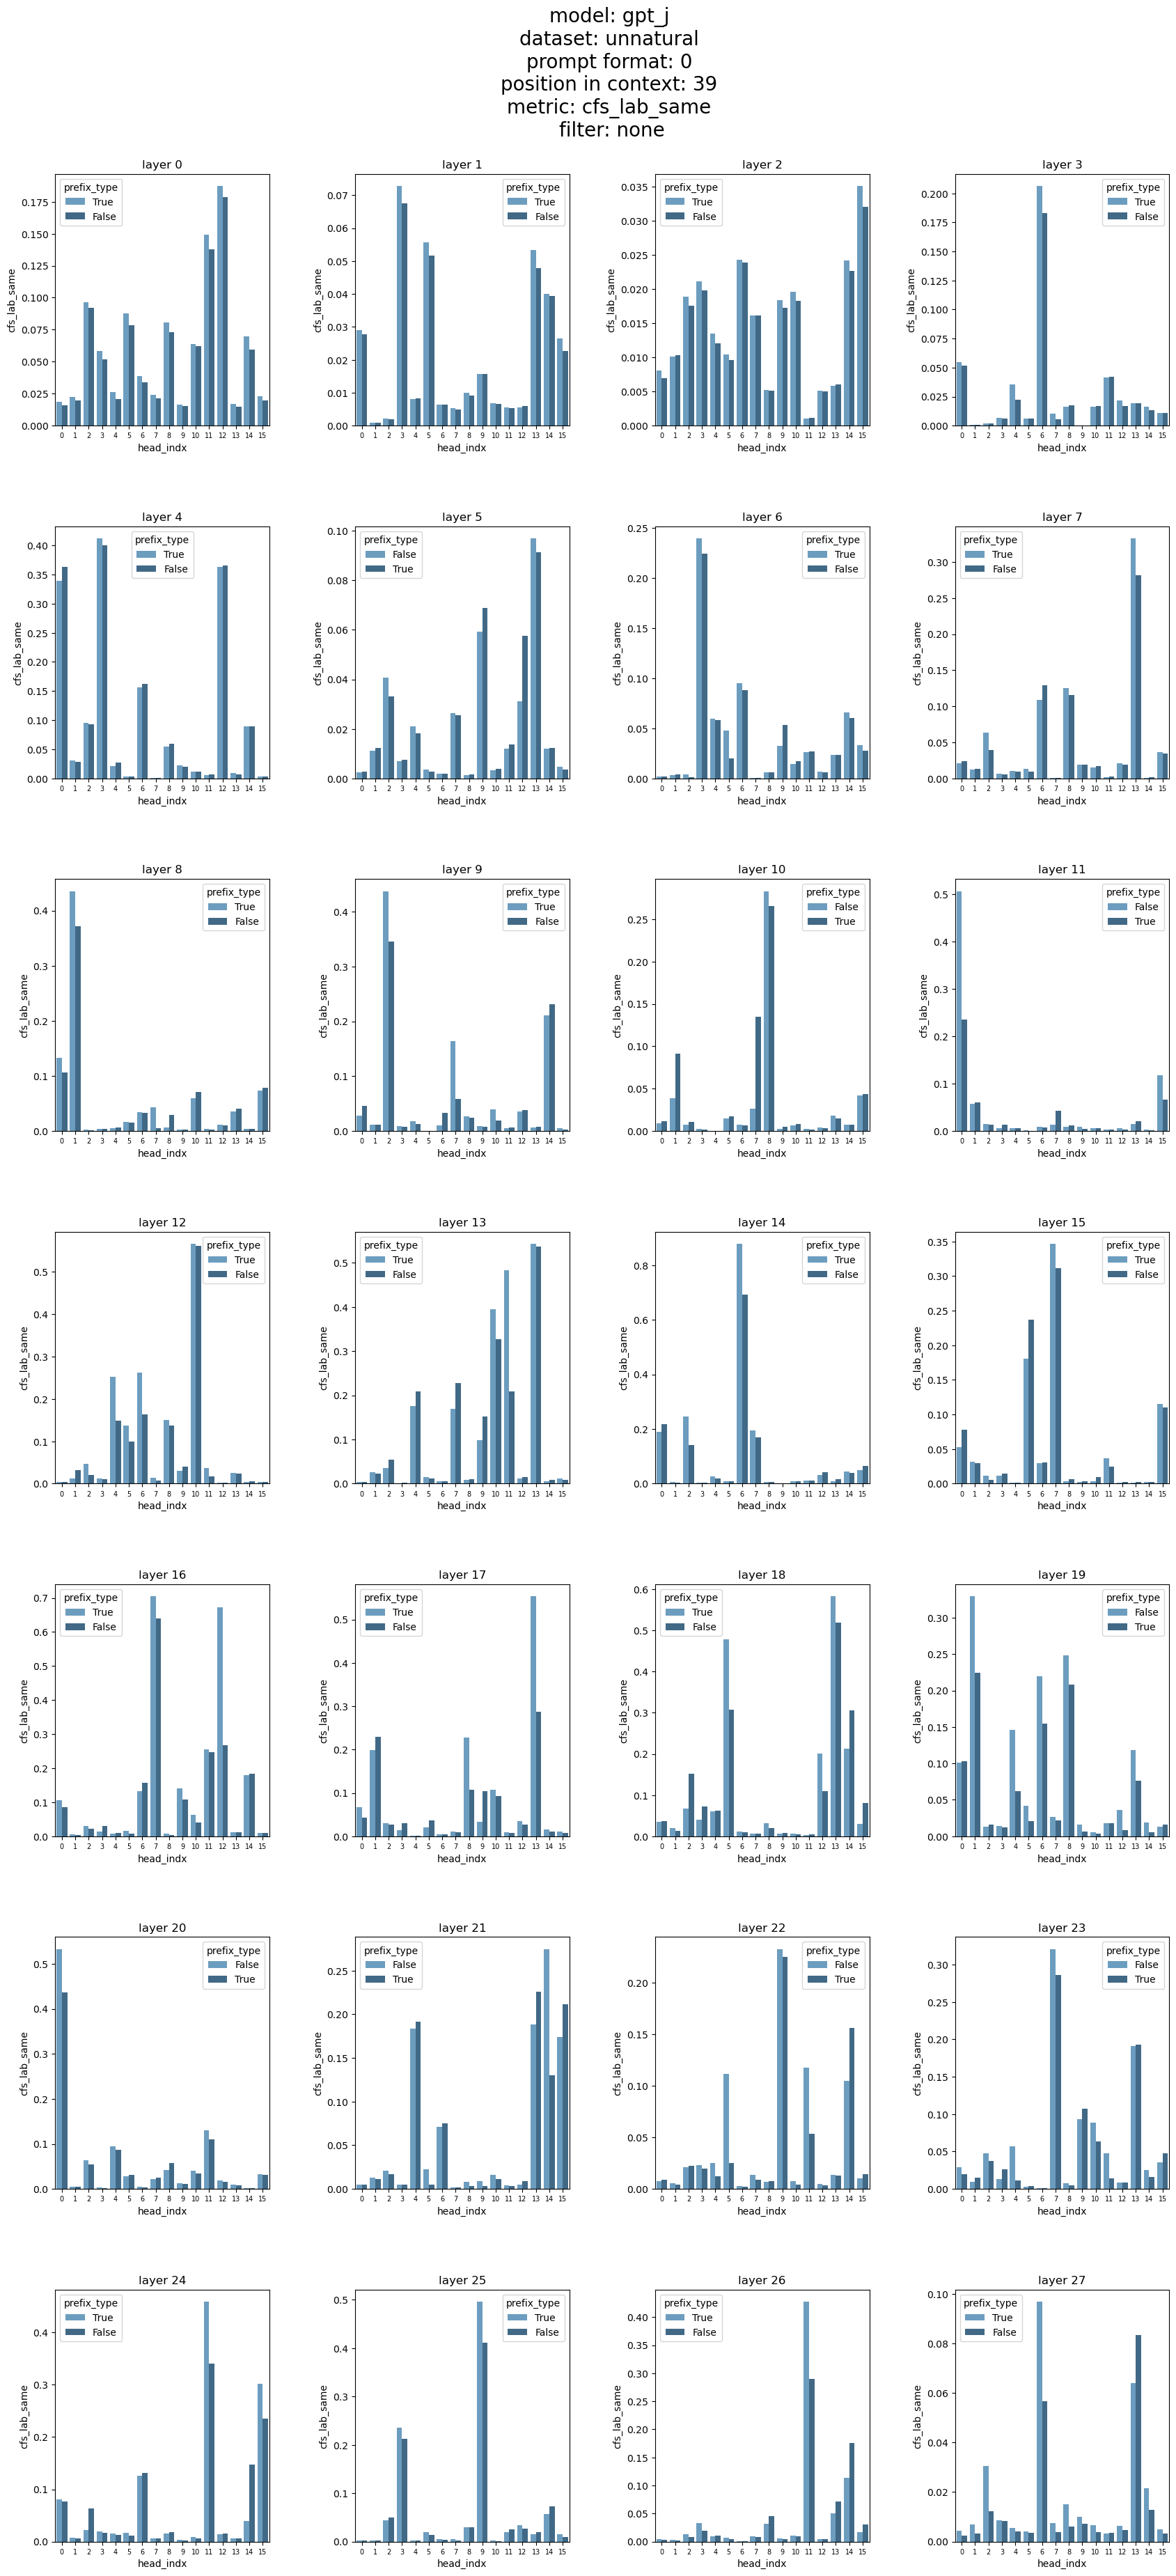

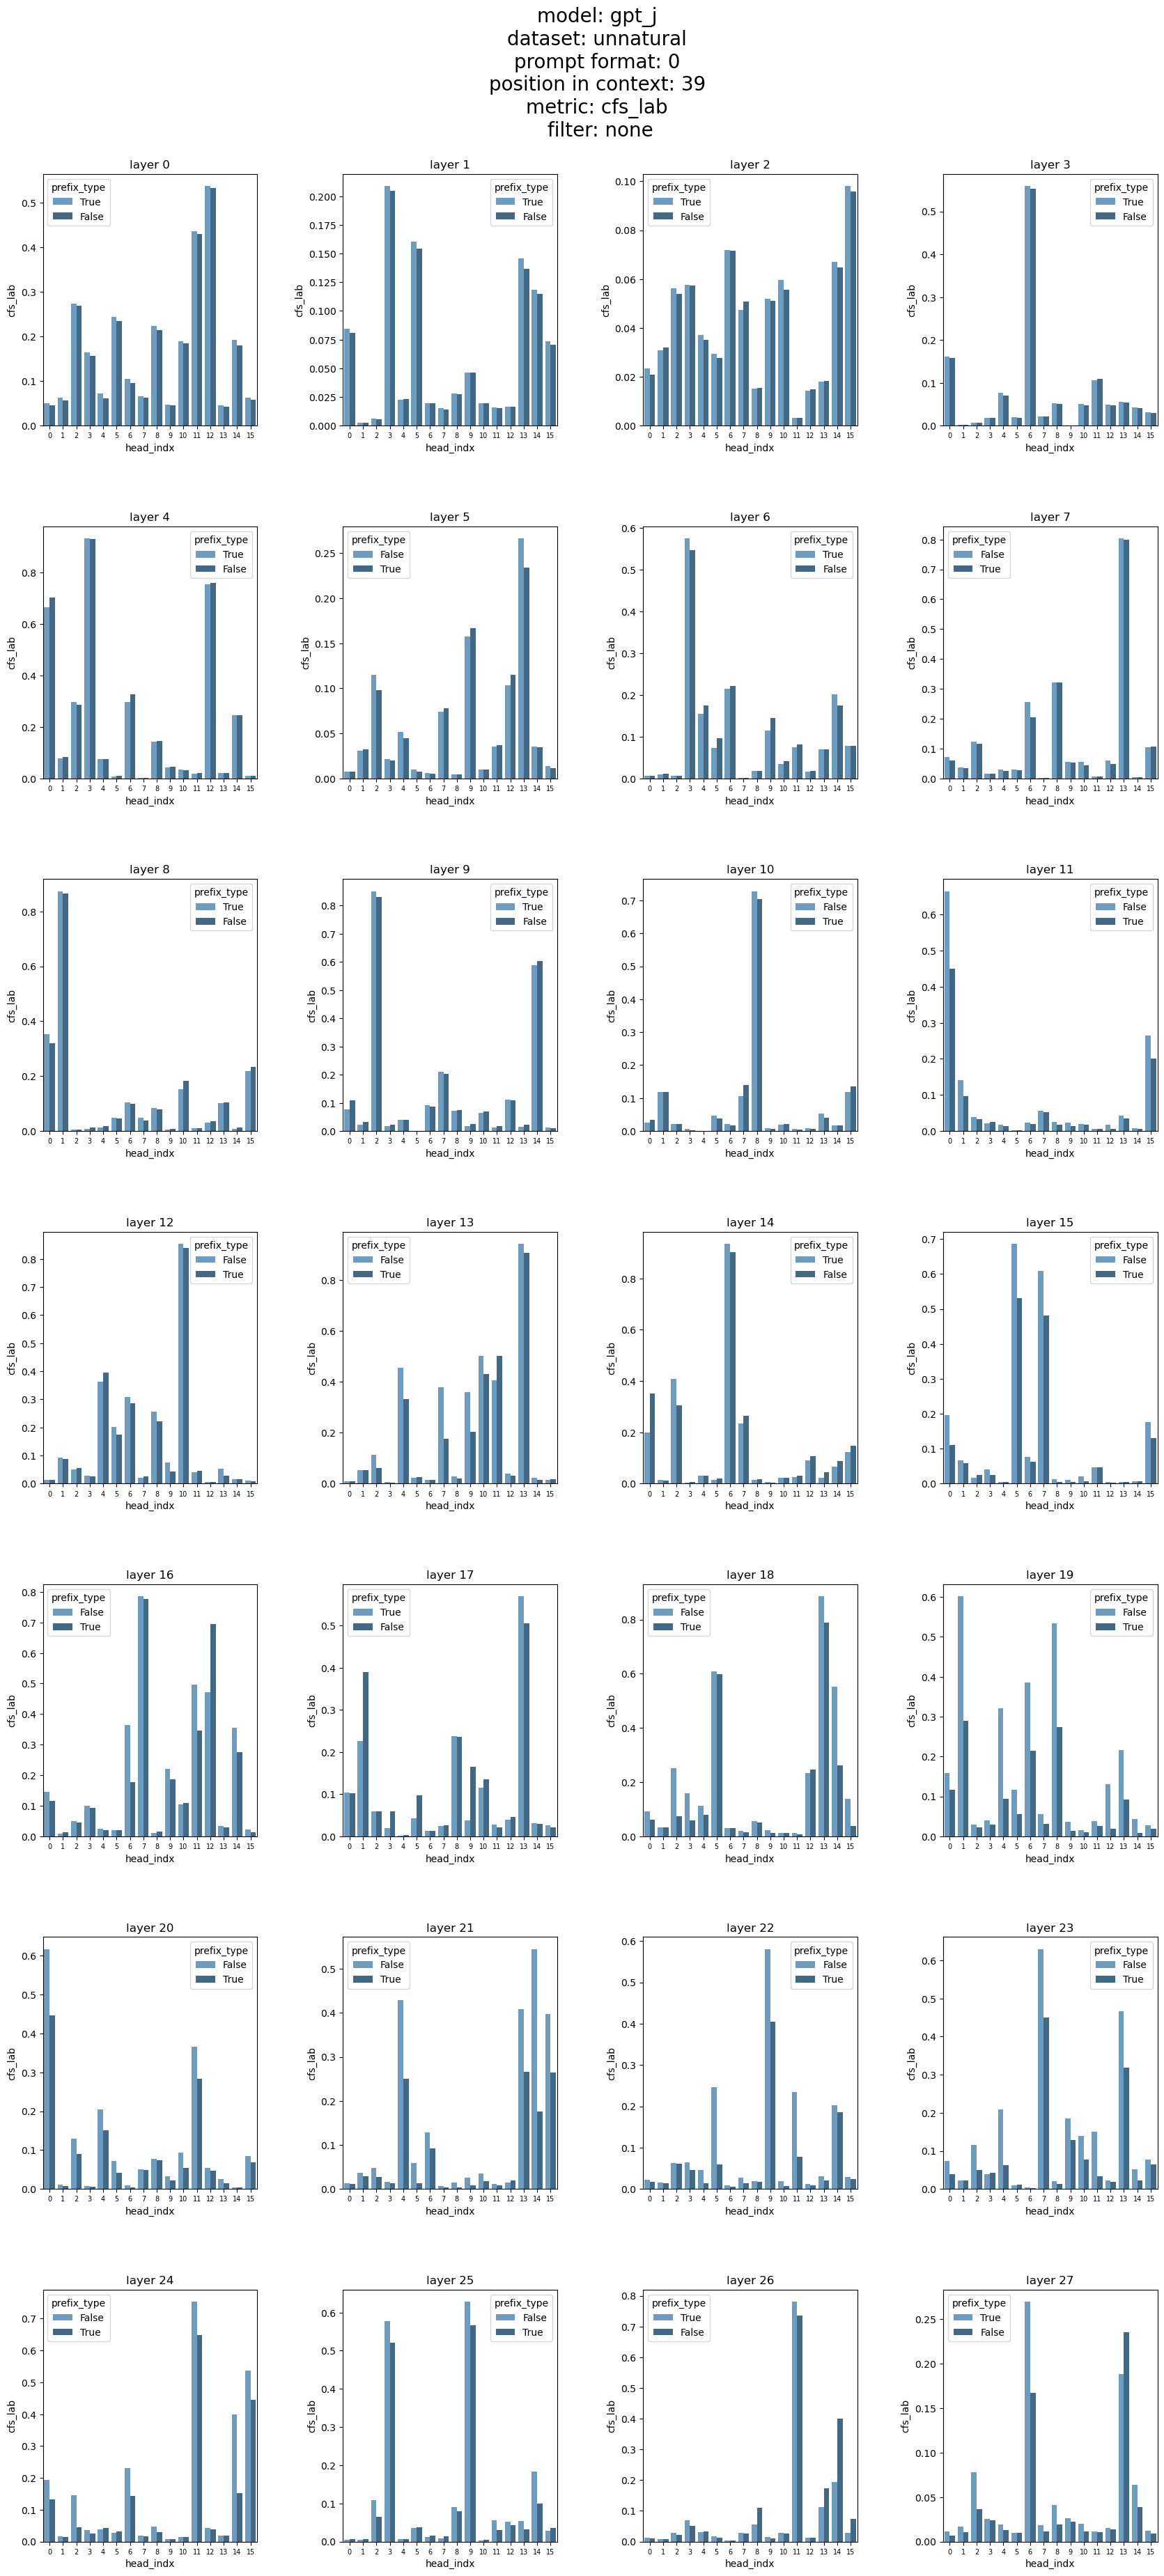

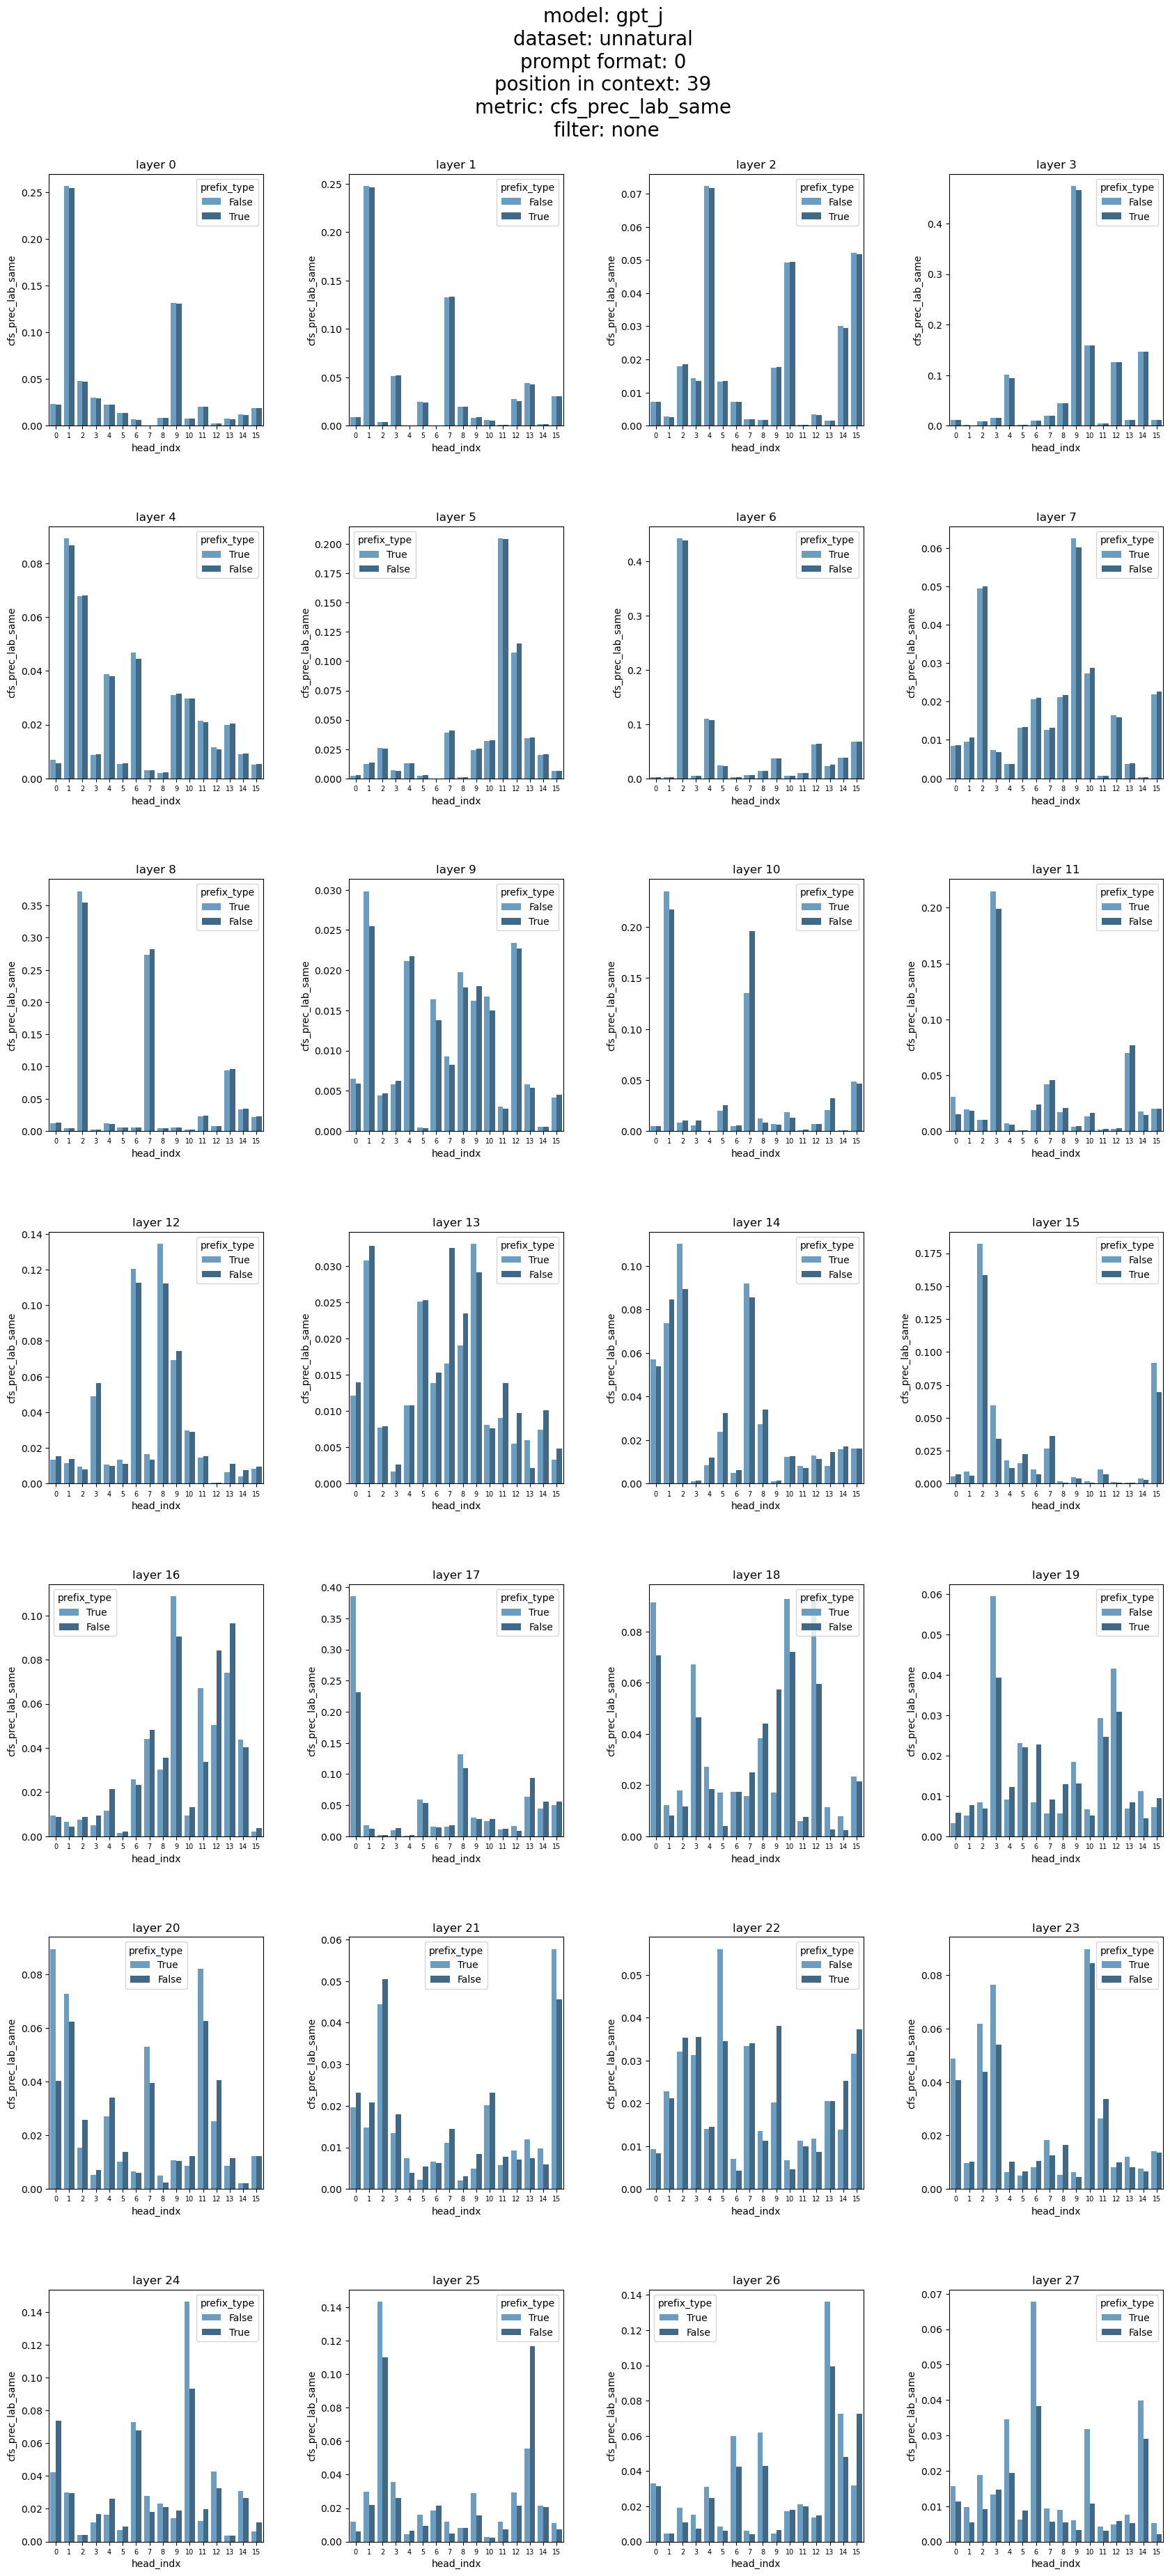

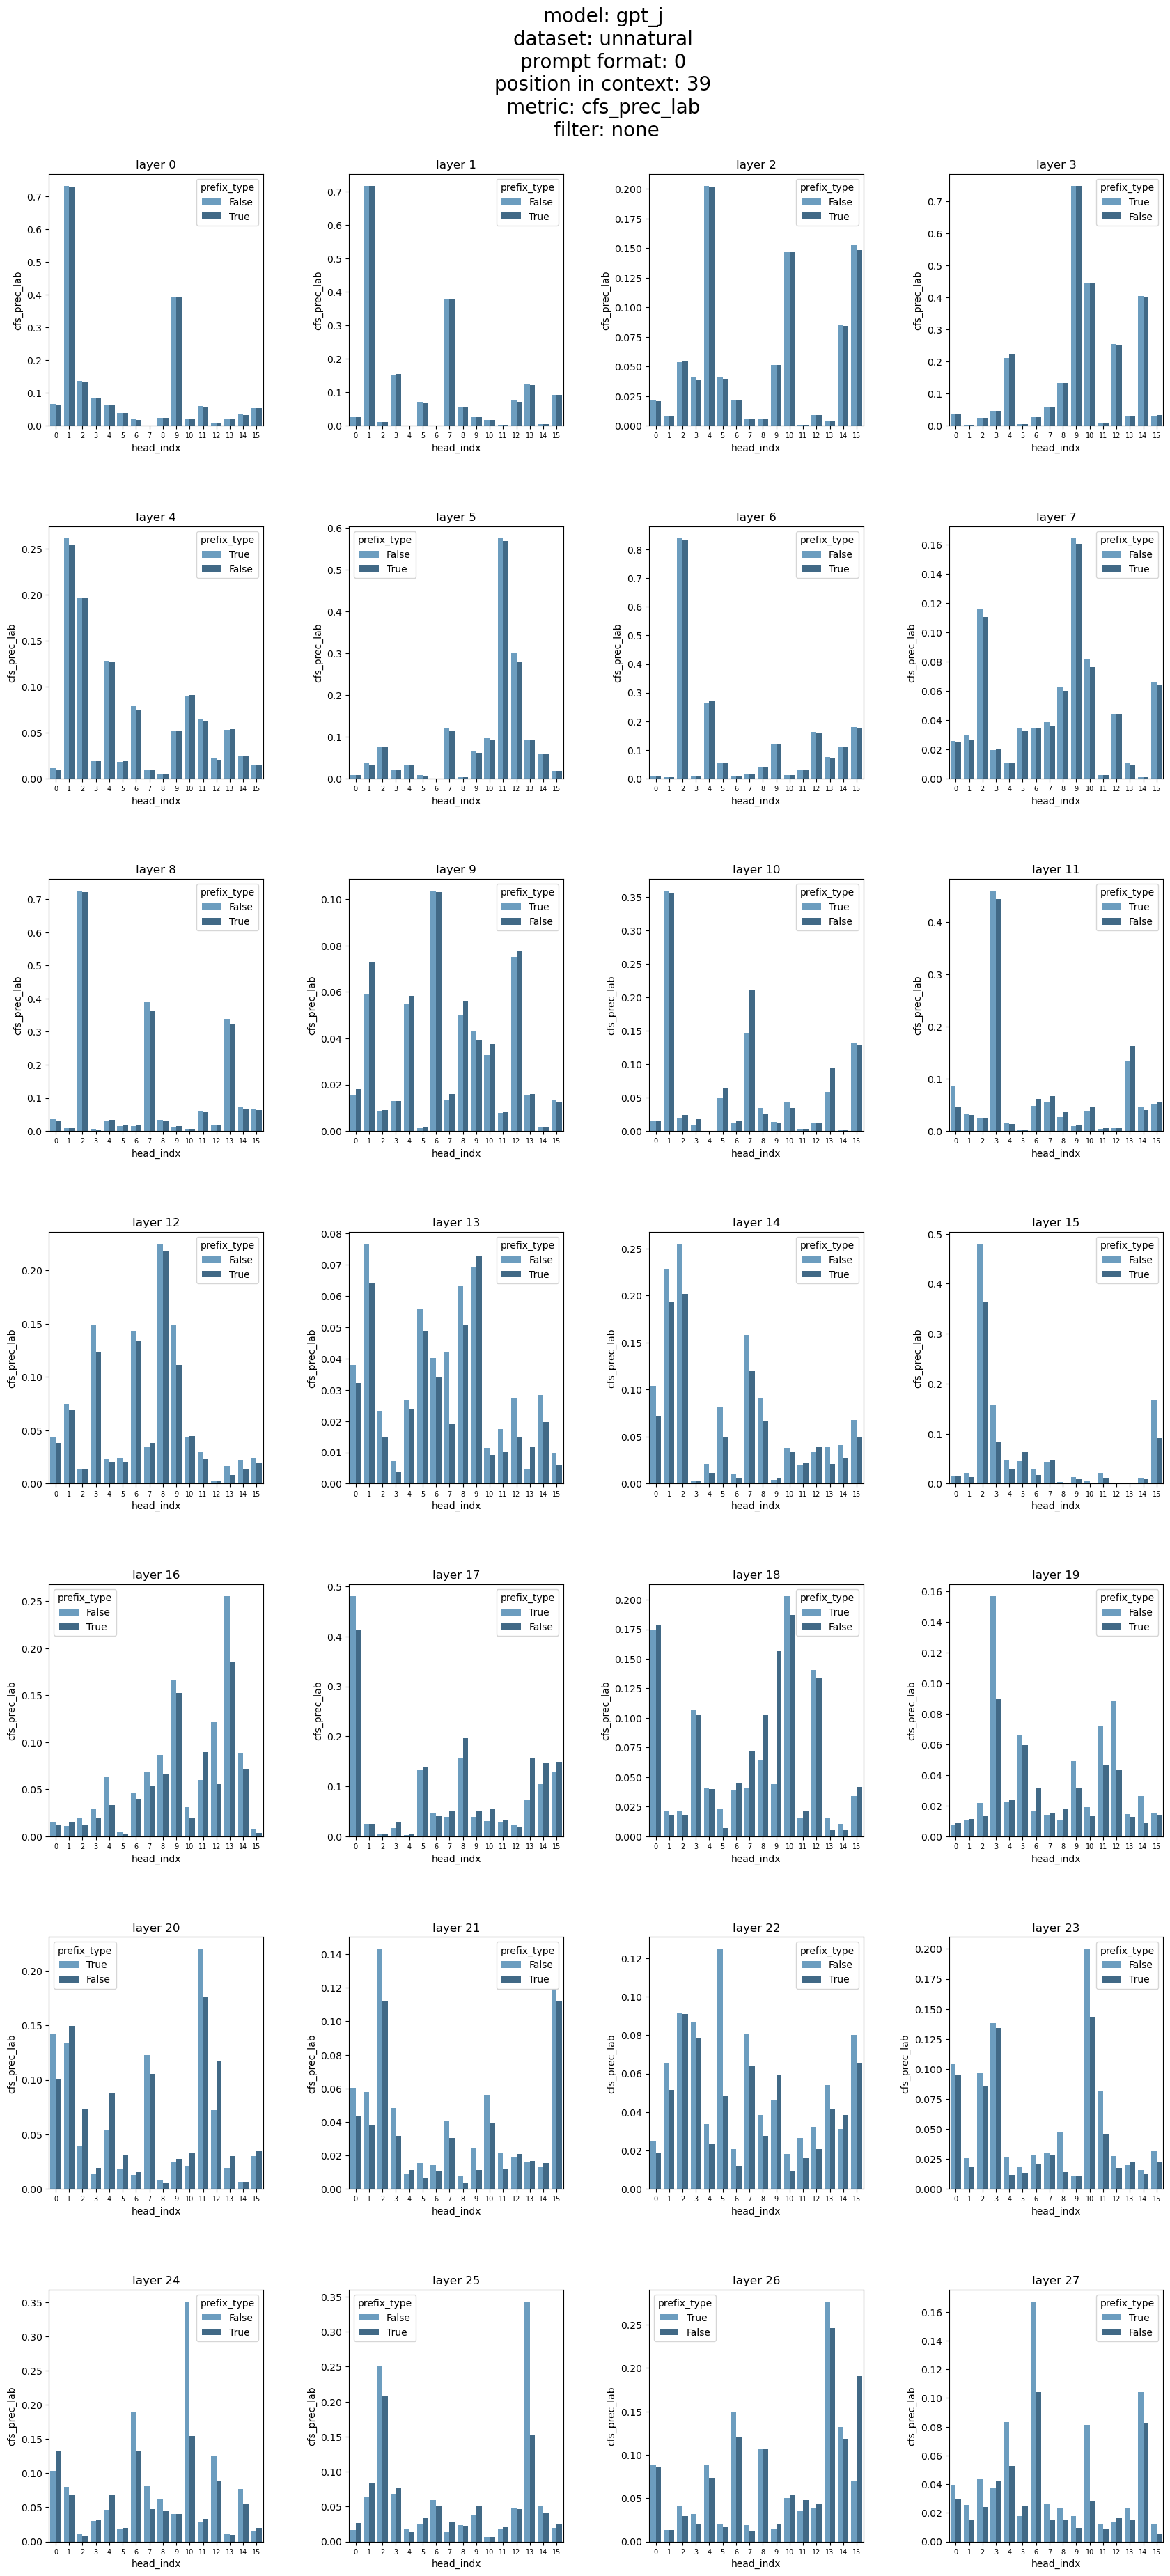

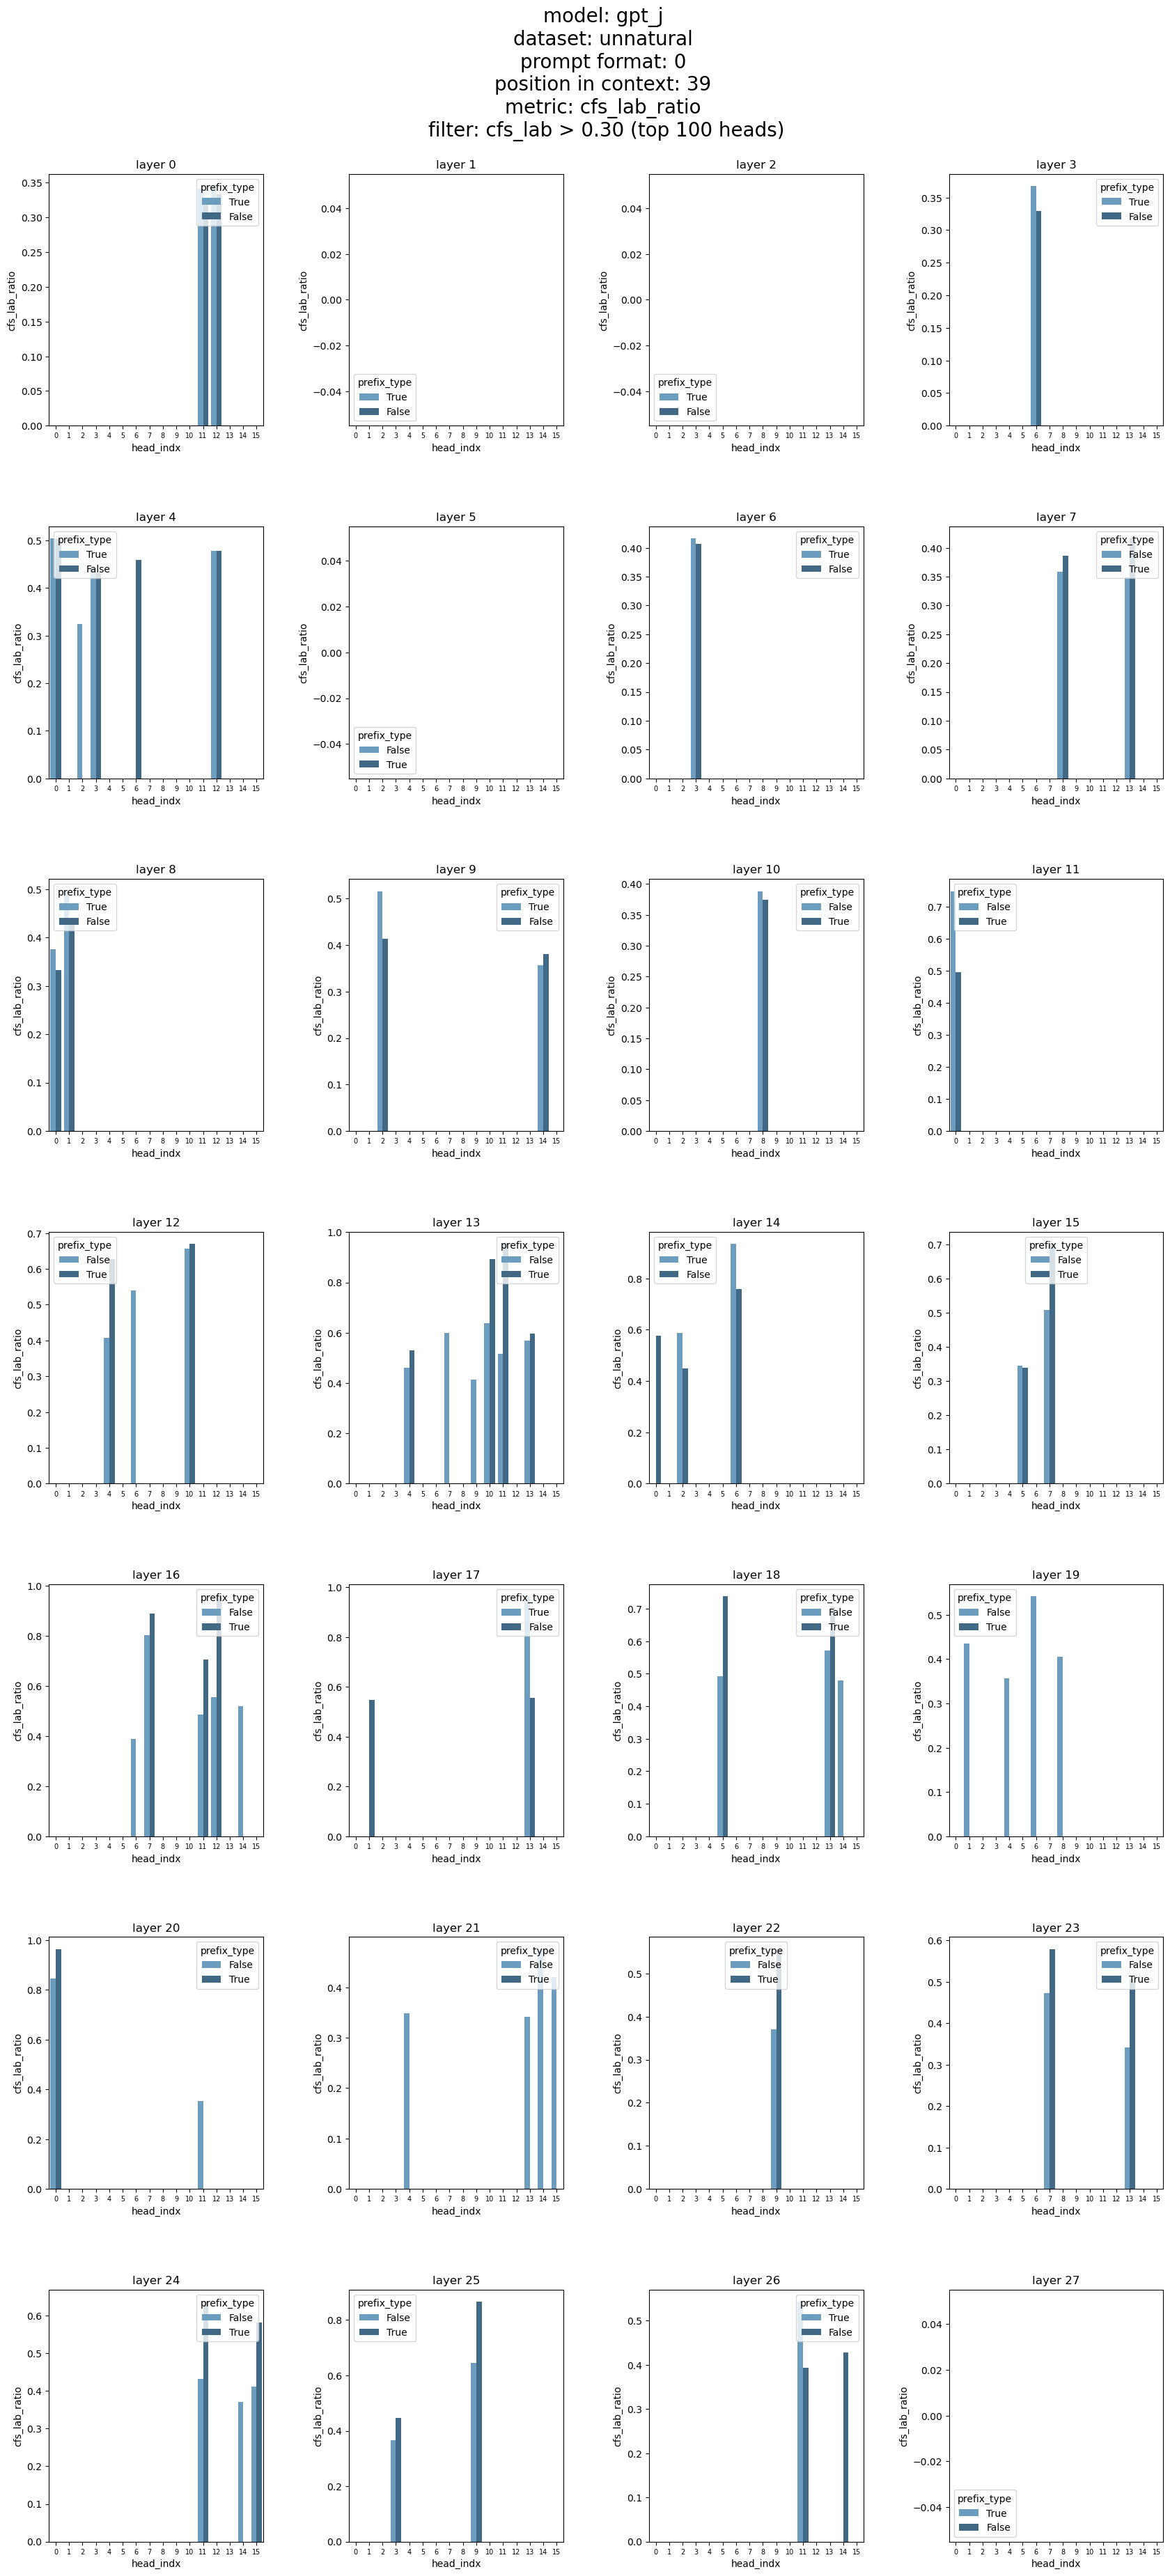

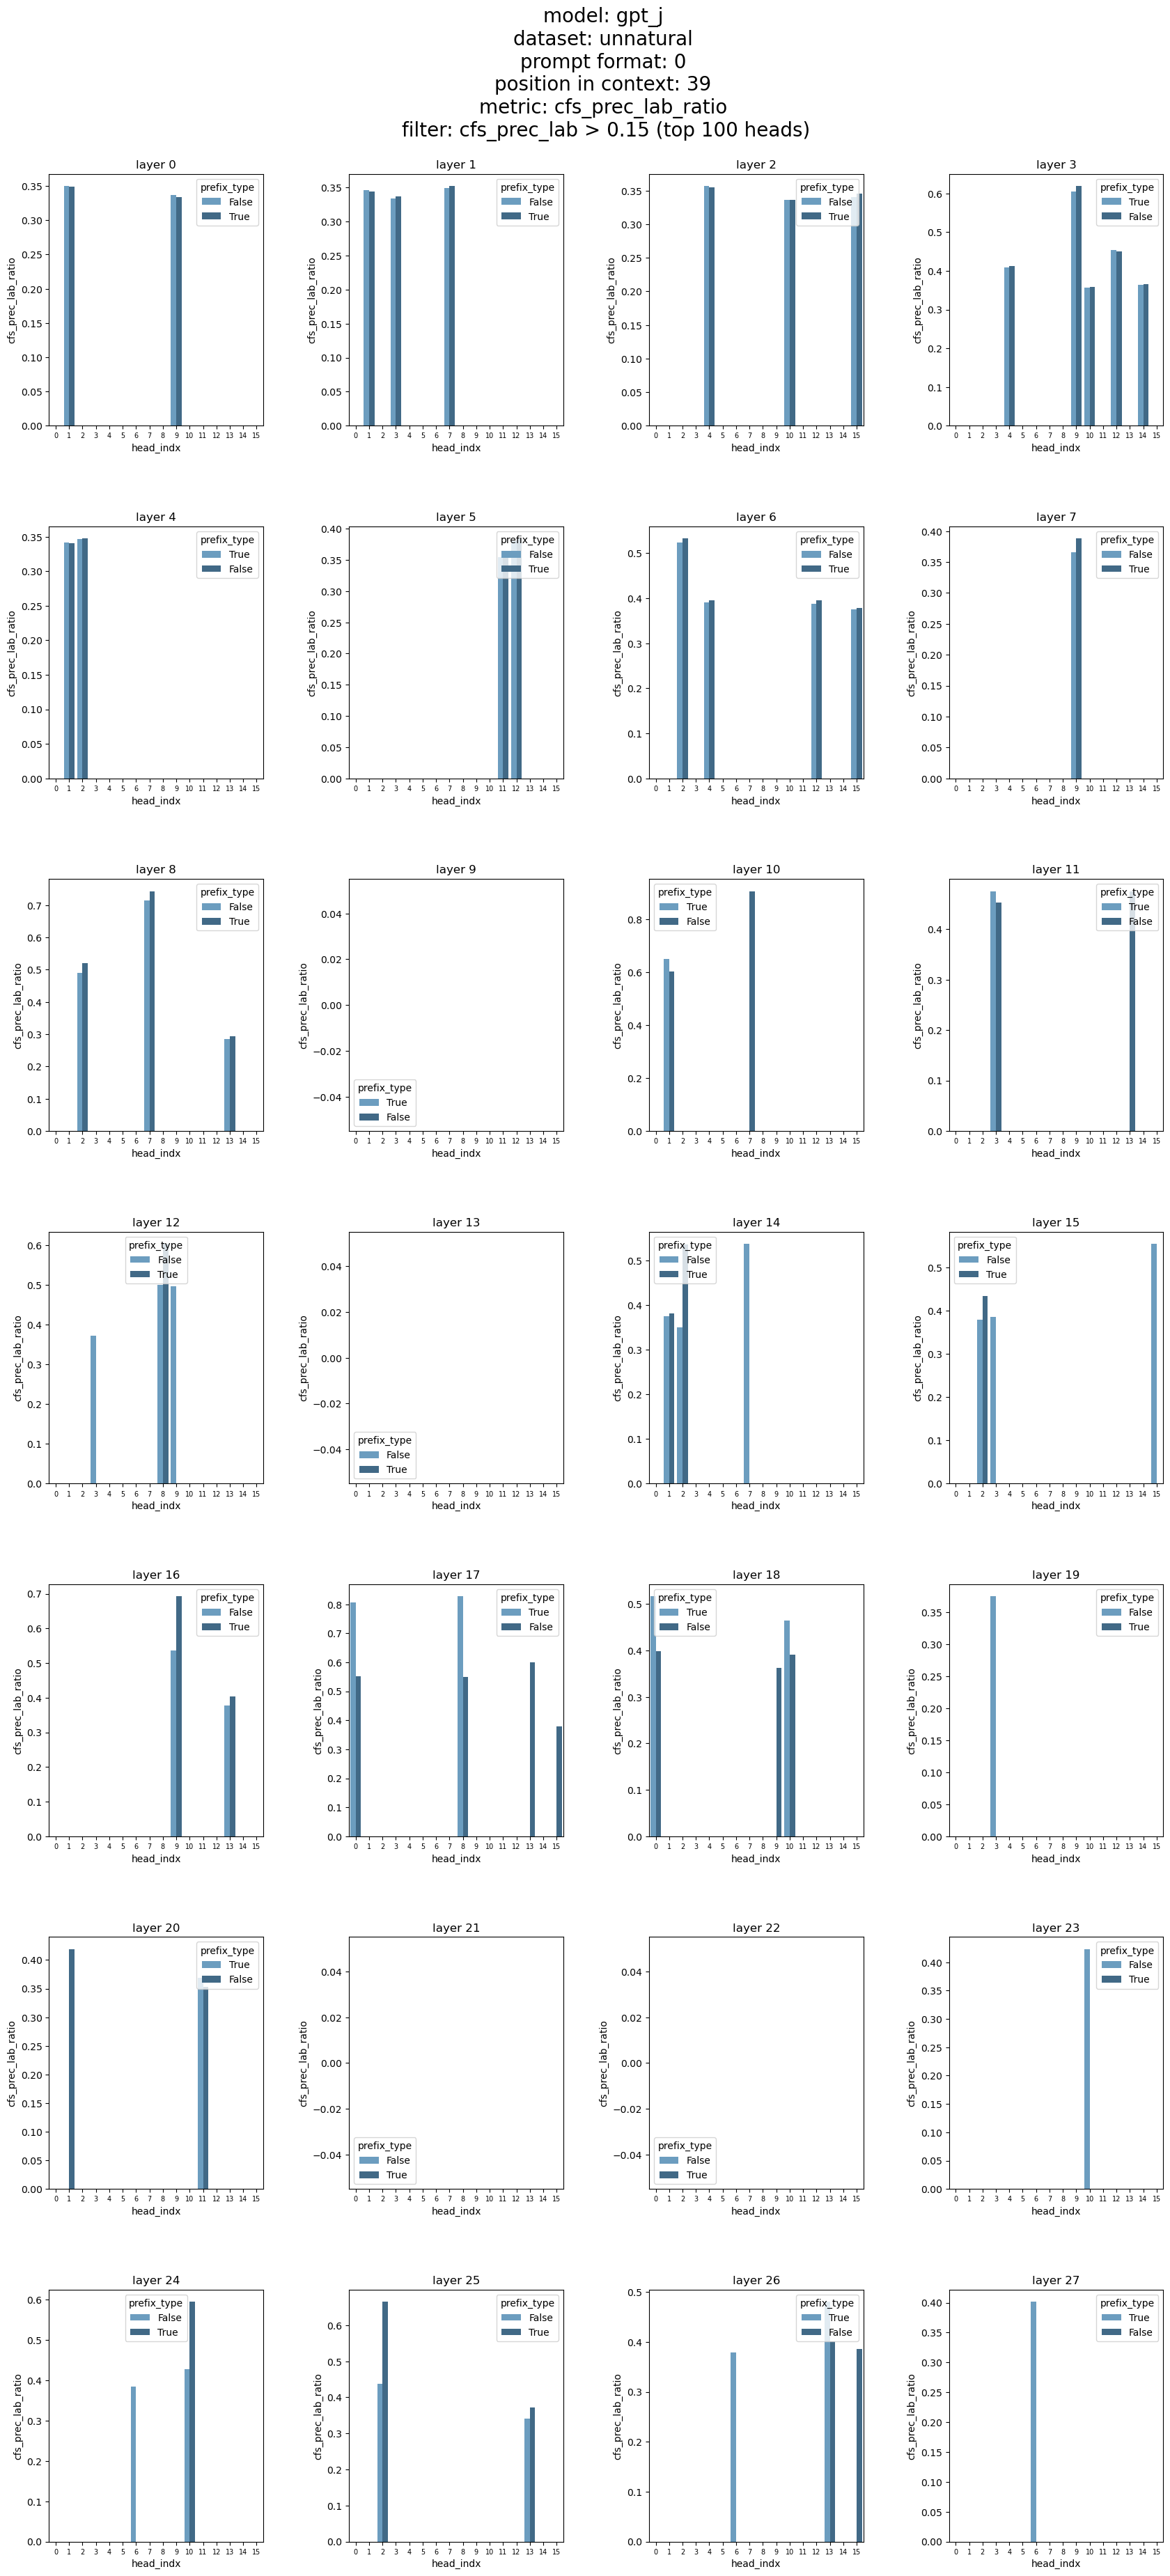

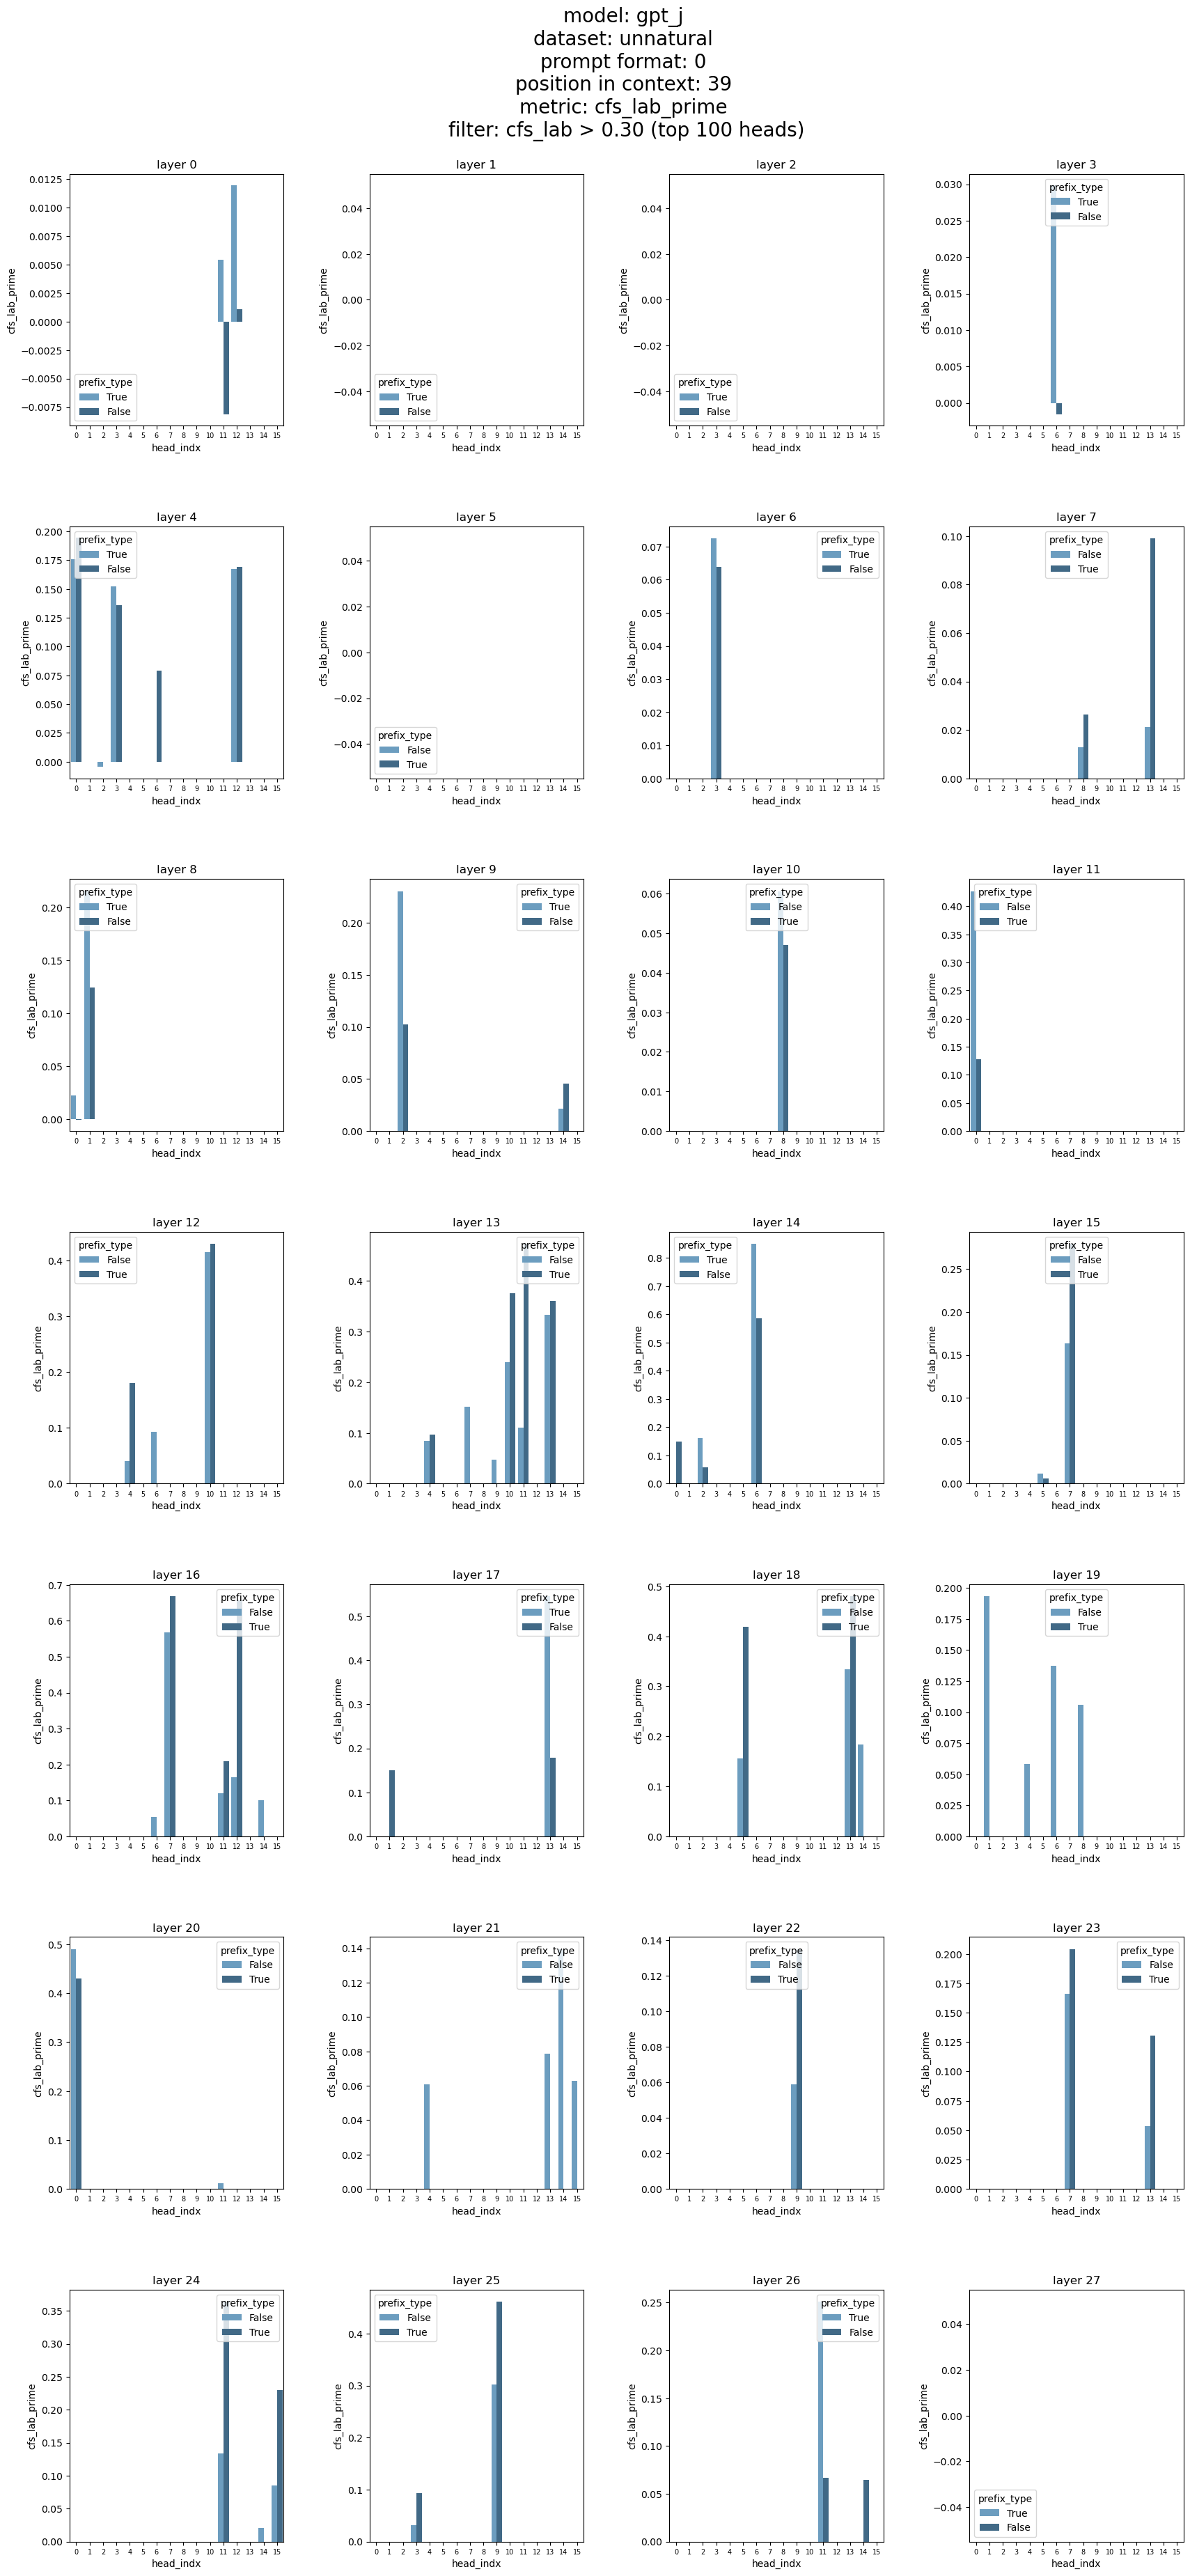

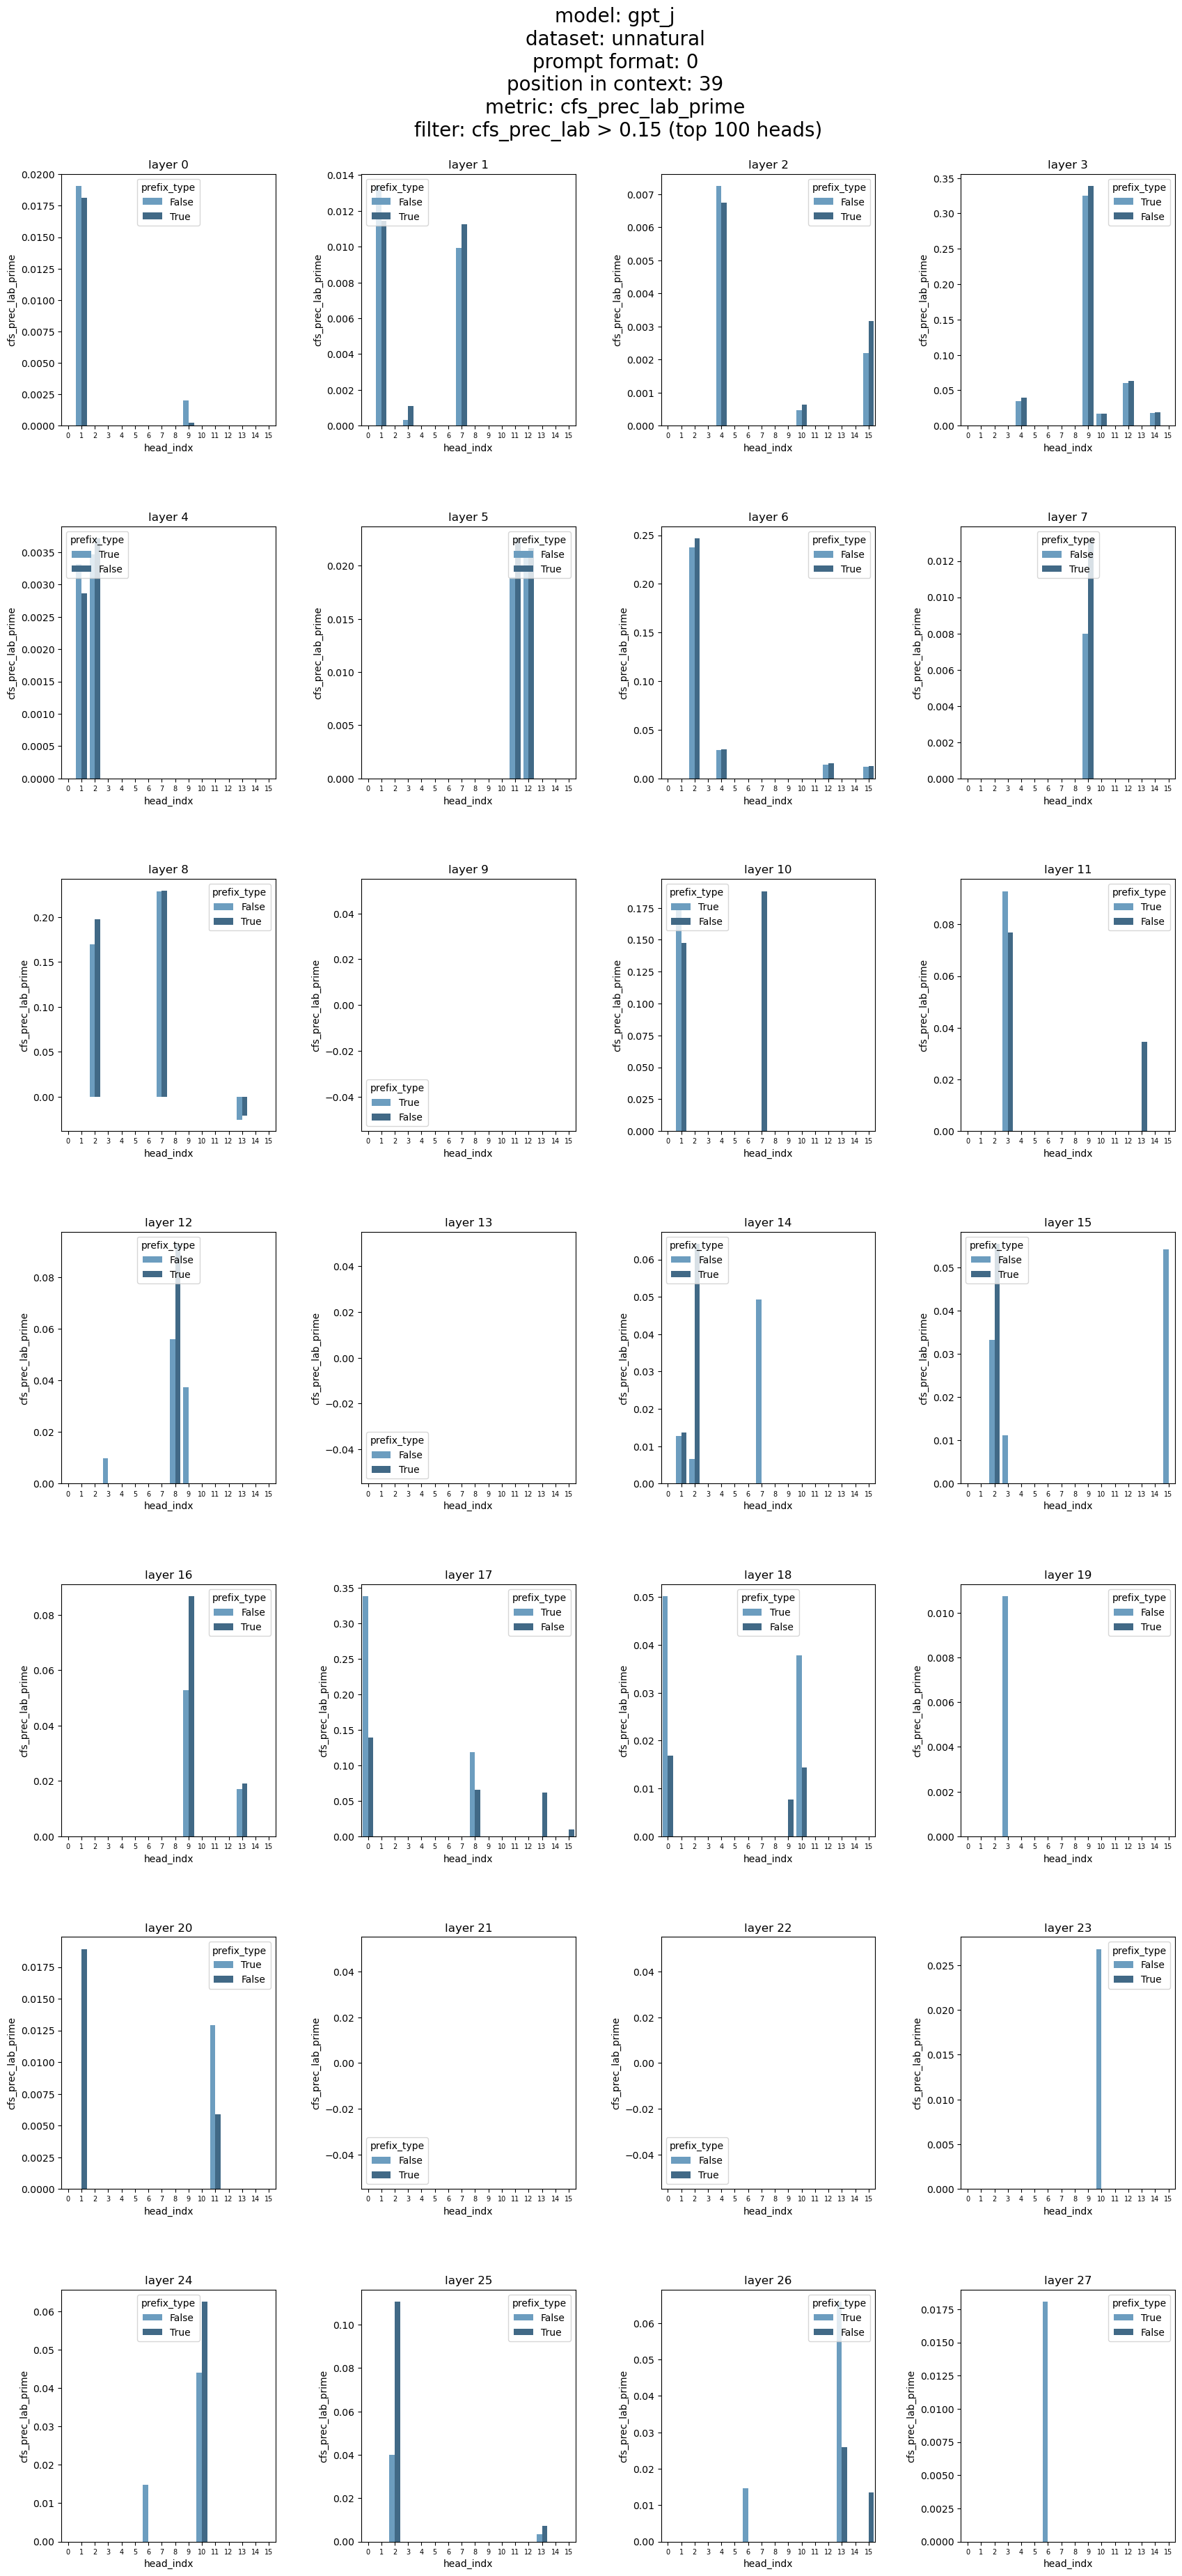

In [14]:
plot_attn_metrics_detailed(
    attn_metrics_df.copy(), metrics, filters, demo_indx, title_params
)

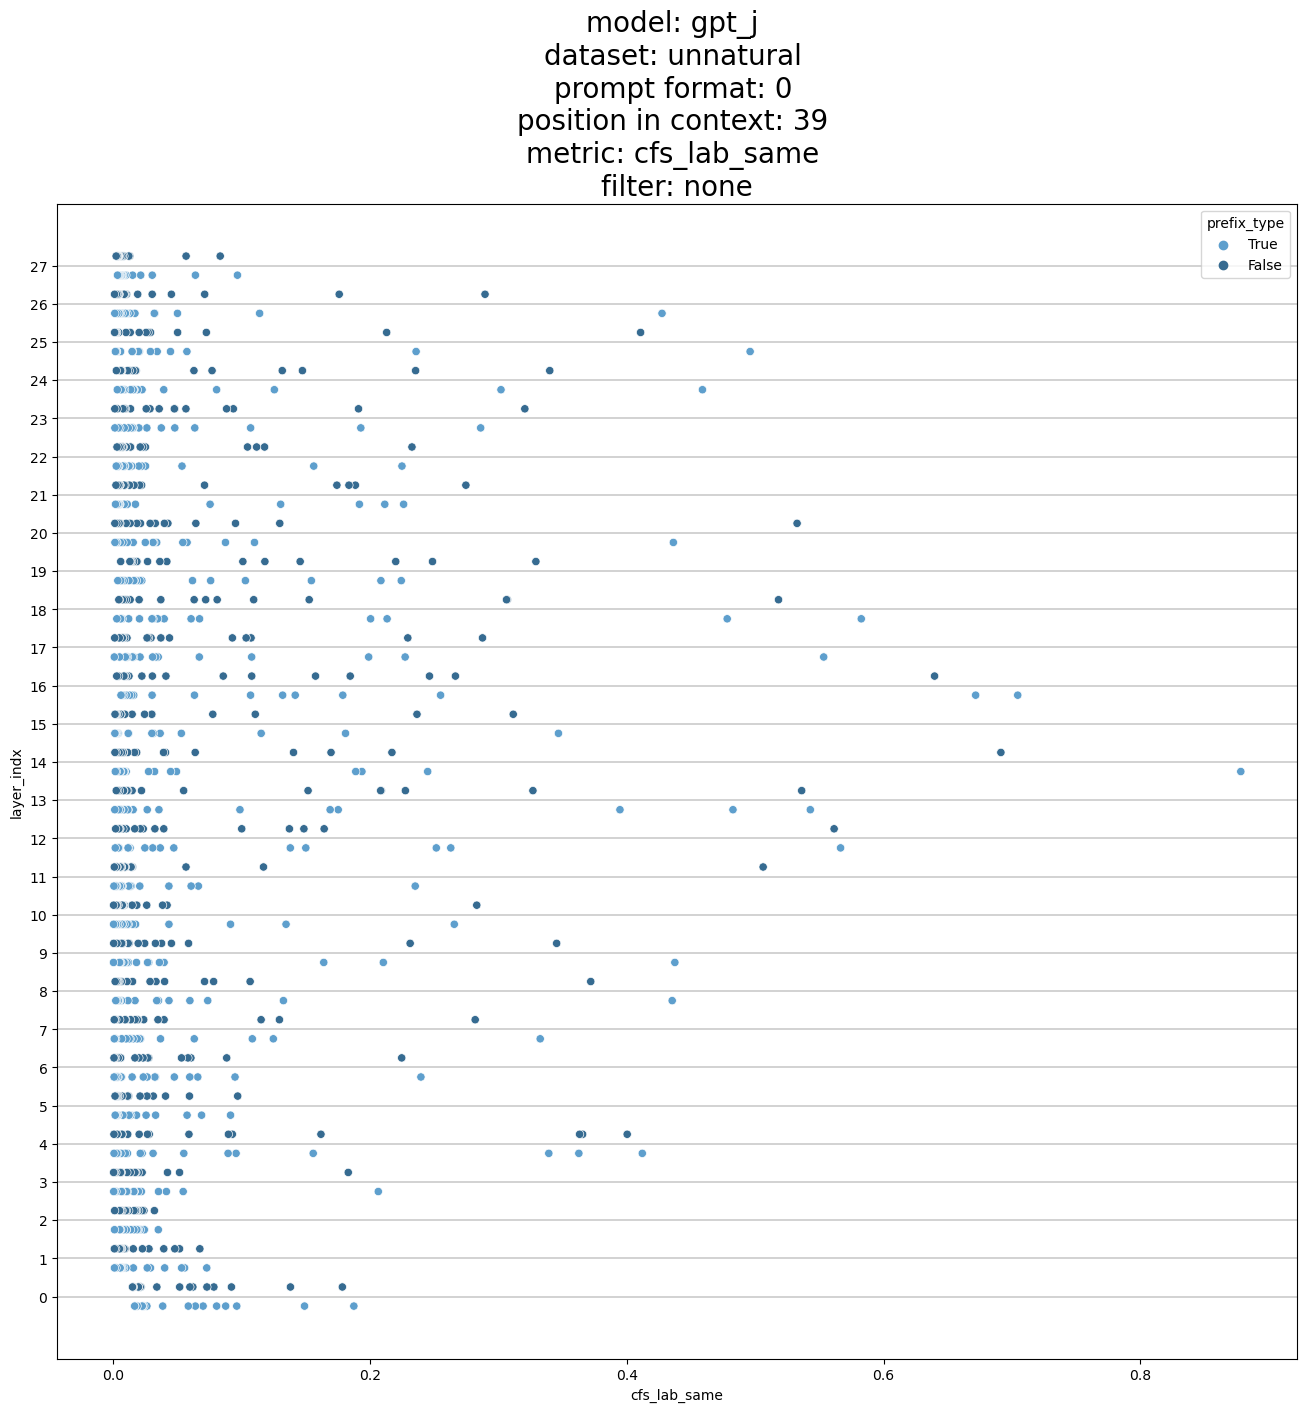

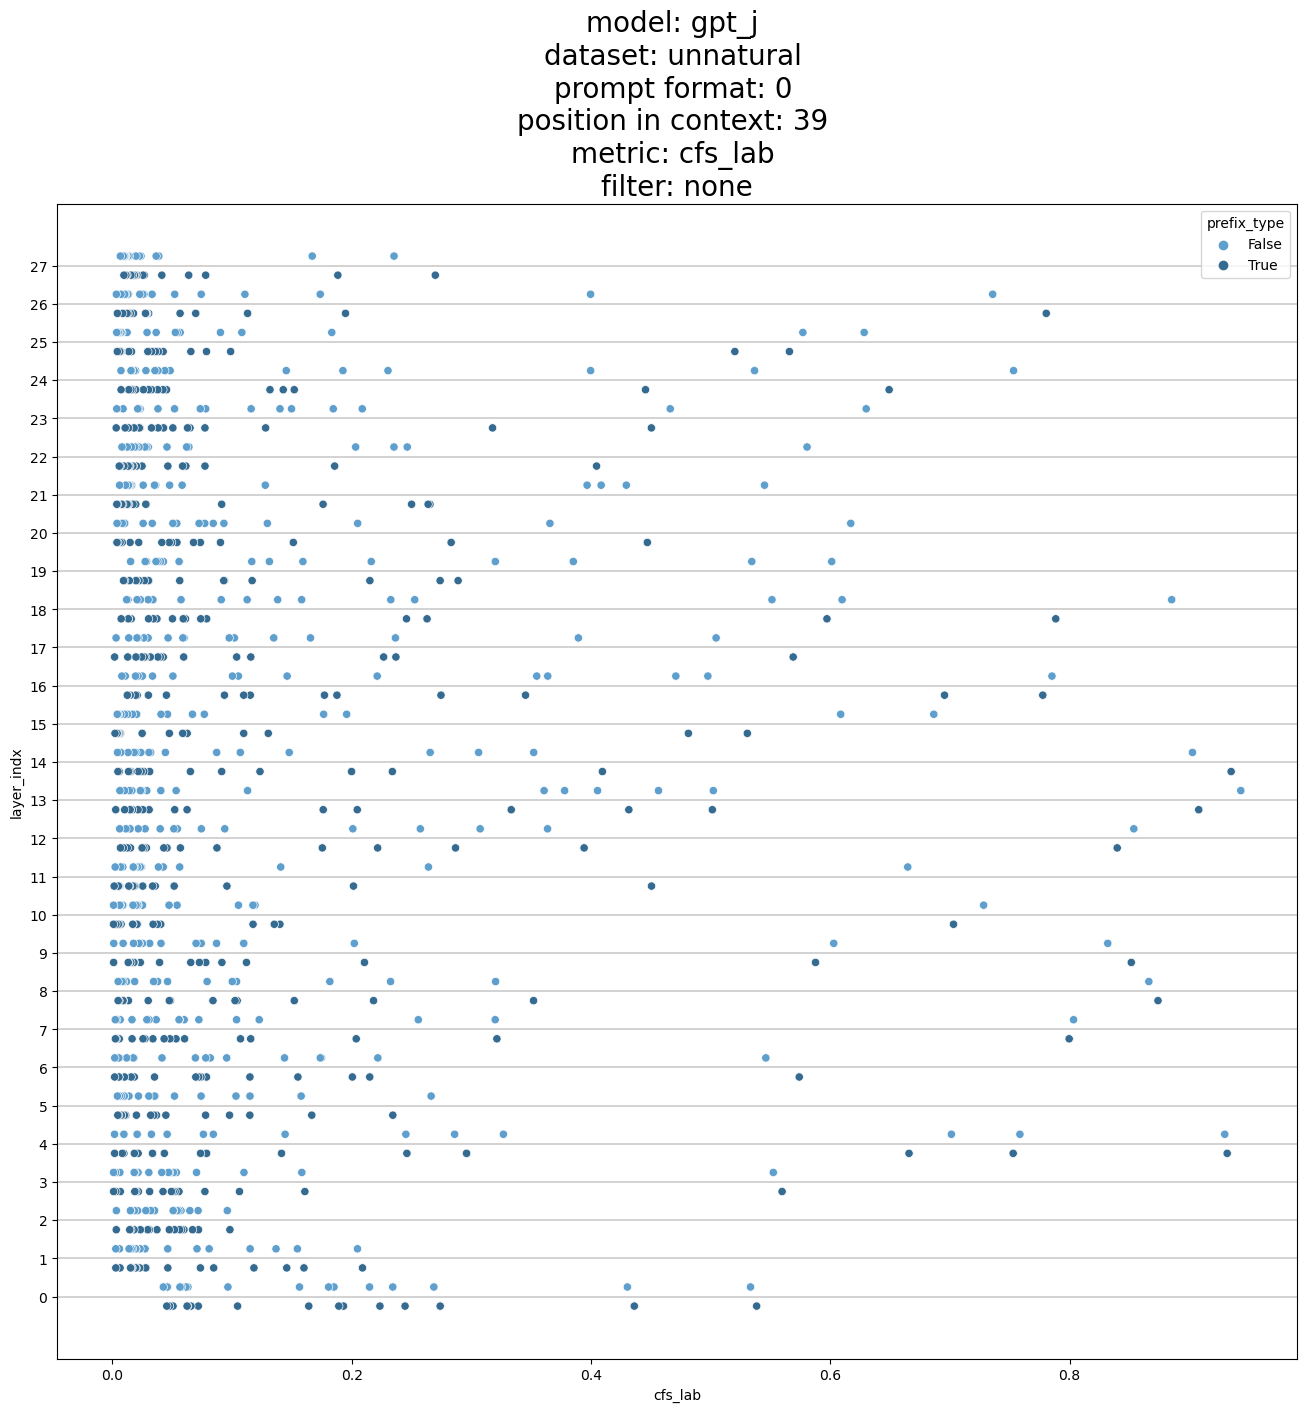

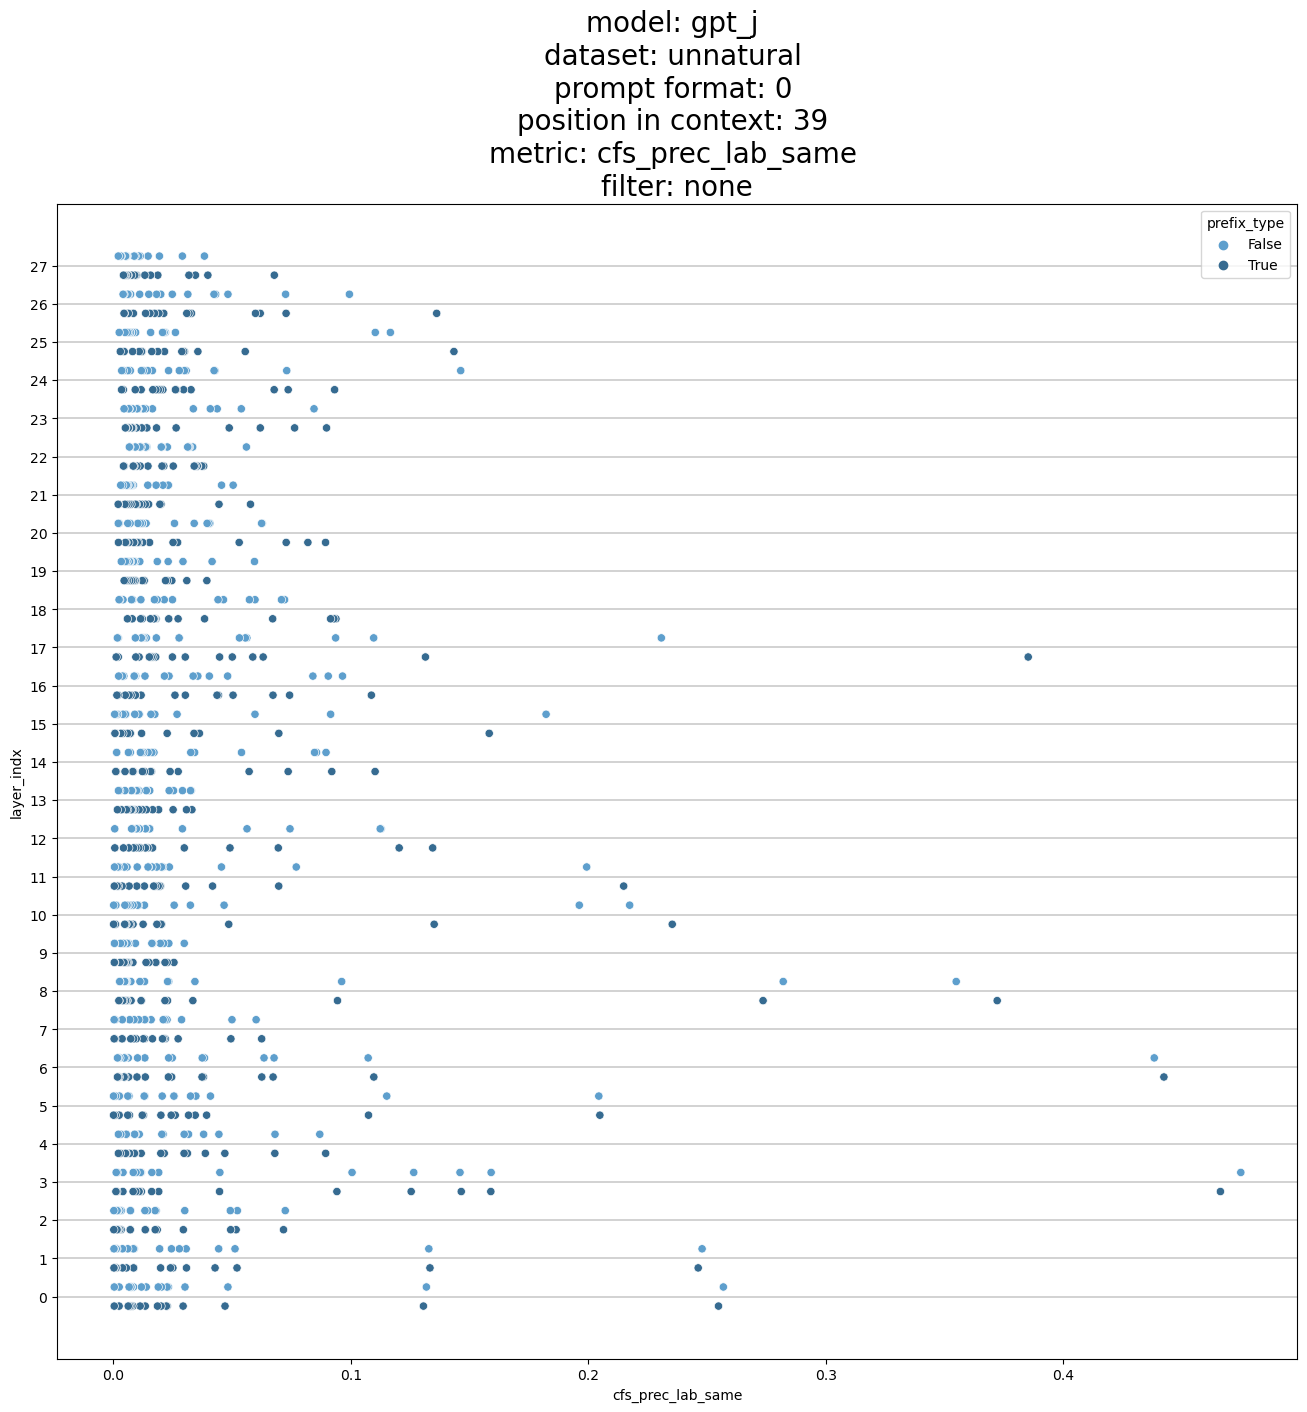

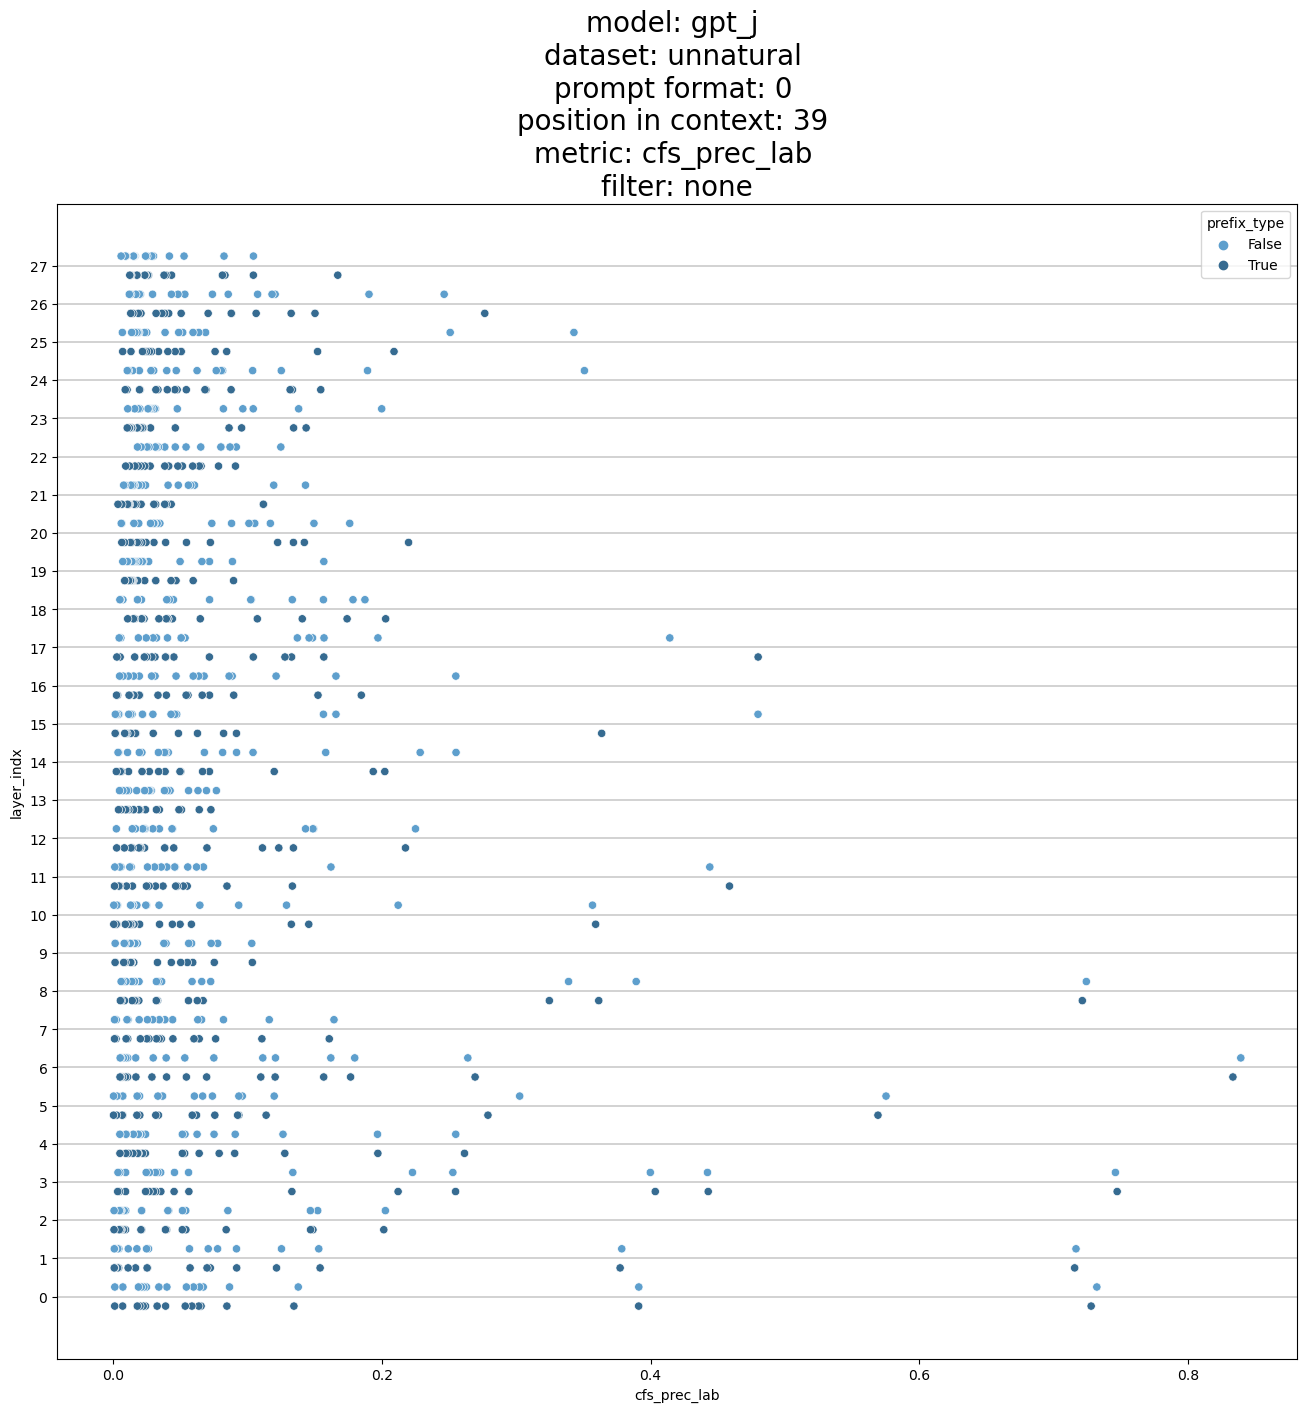

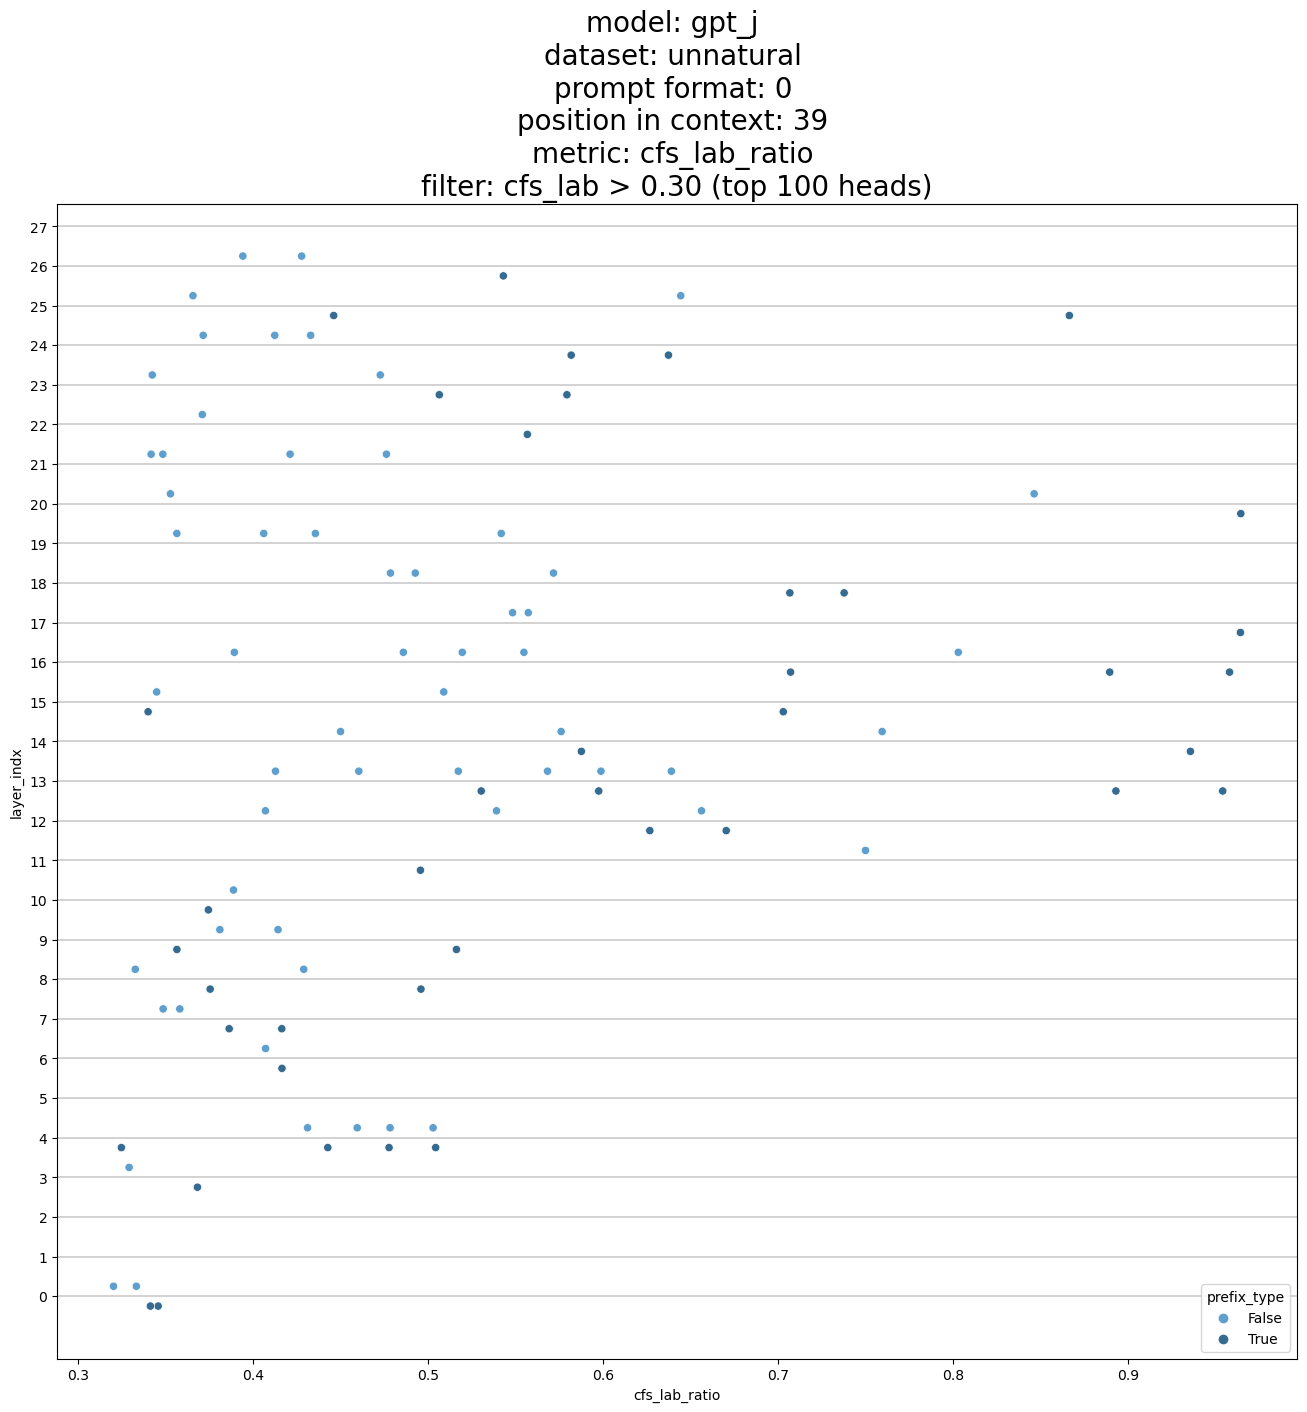

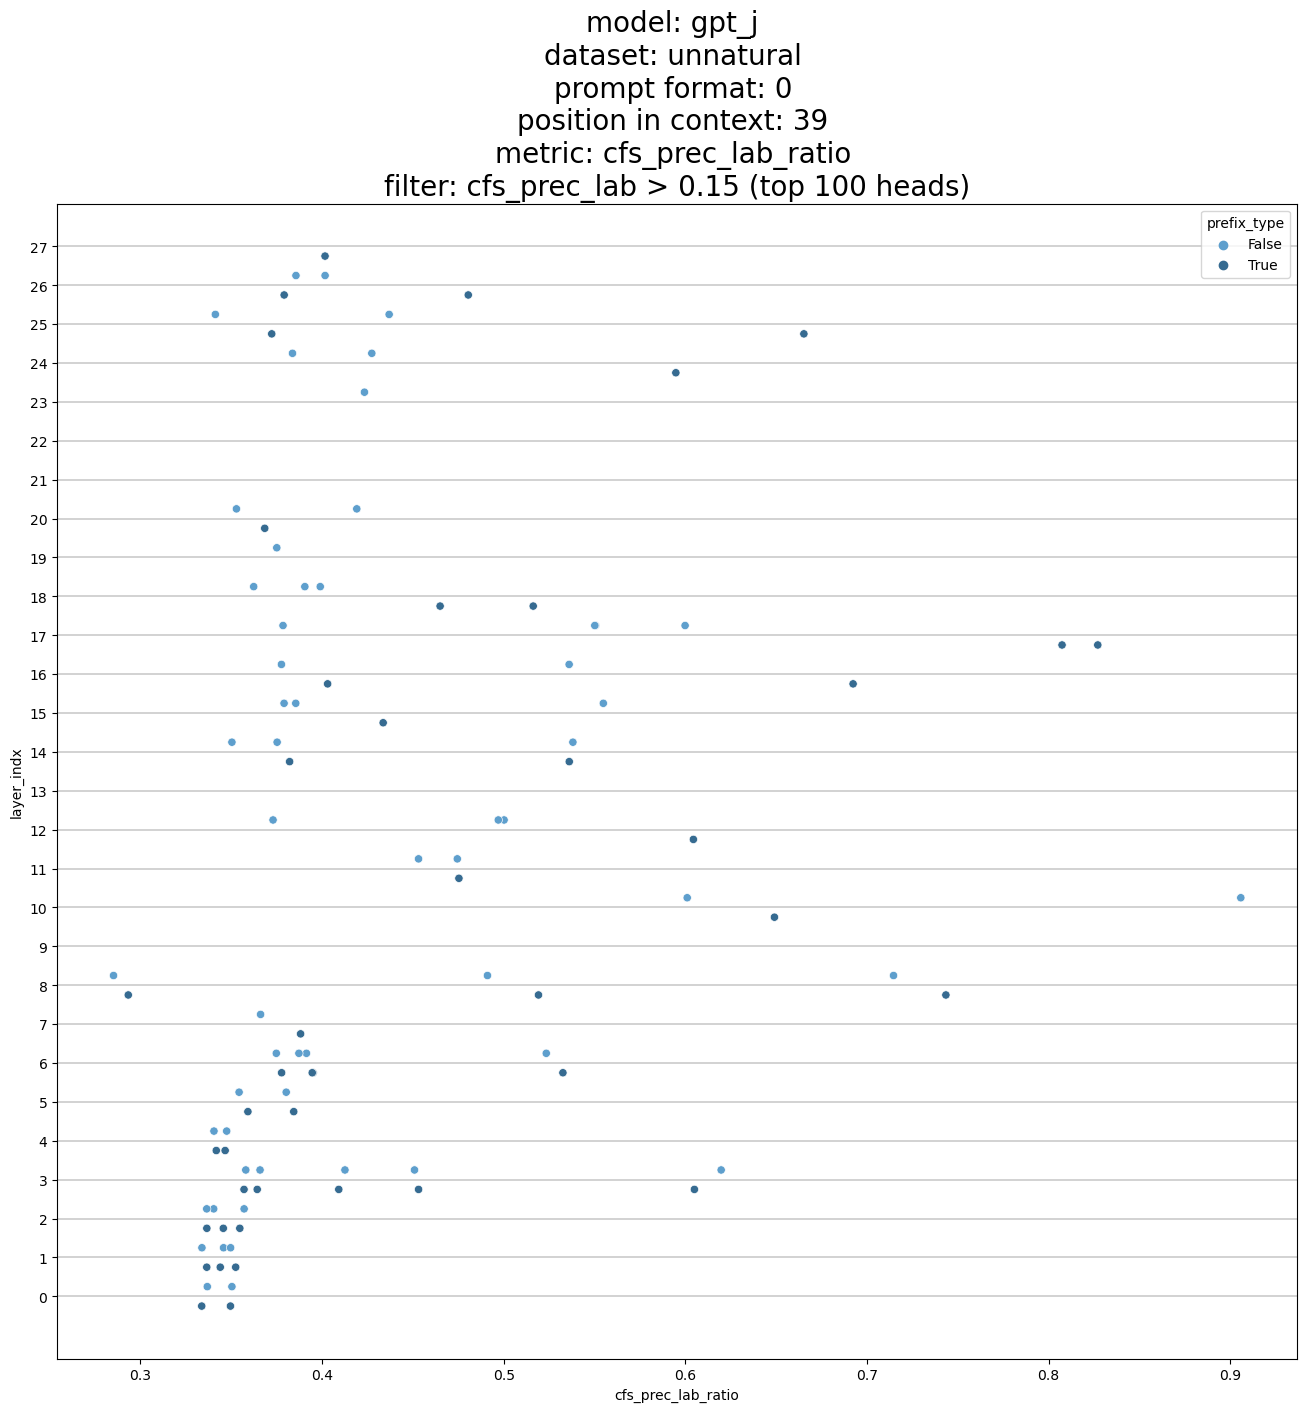

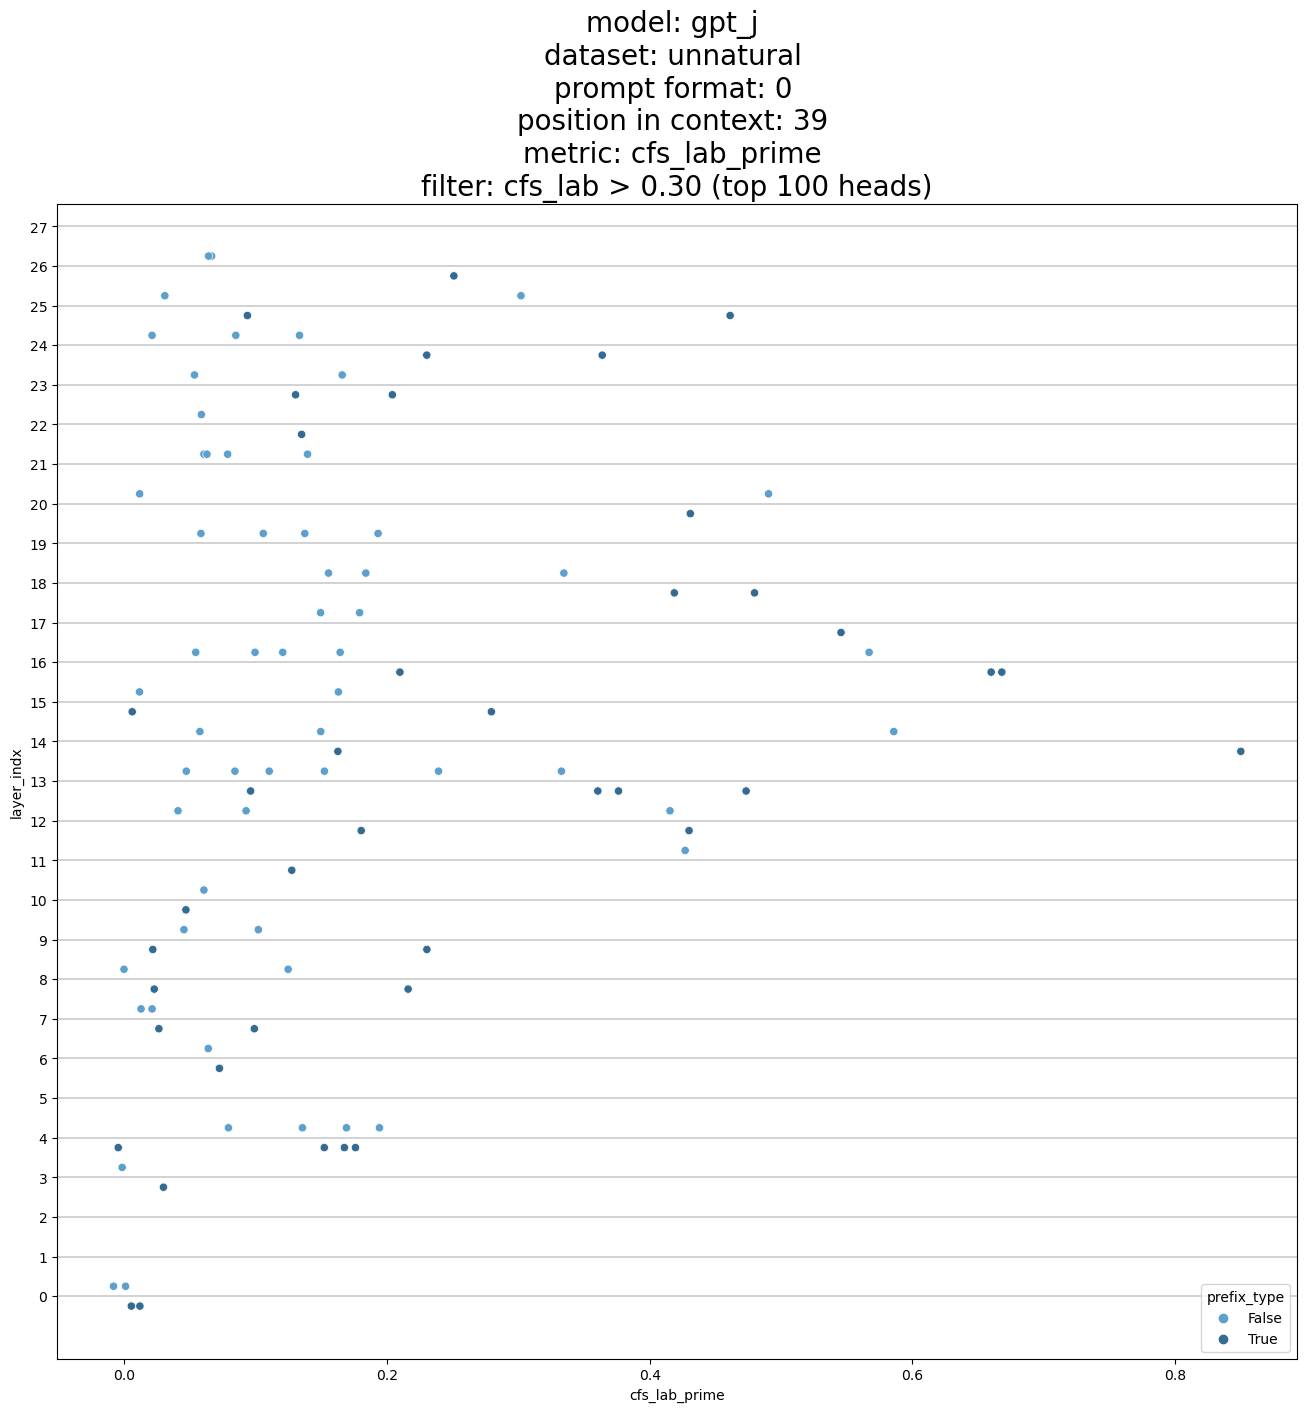

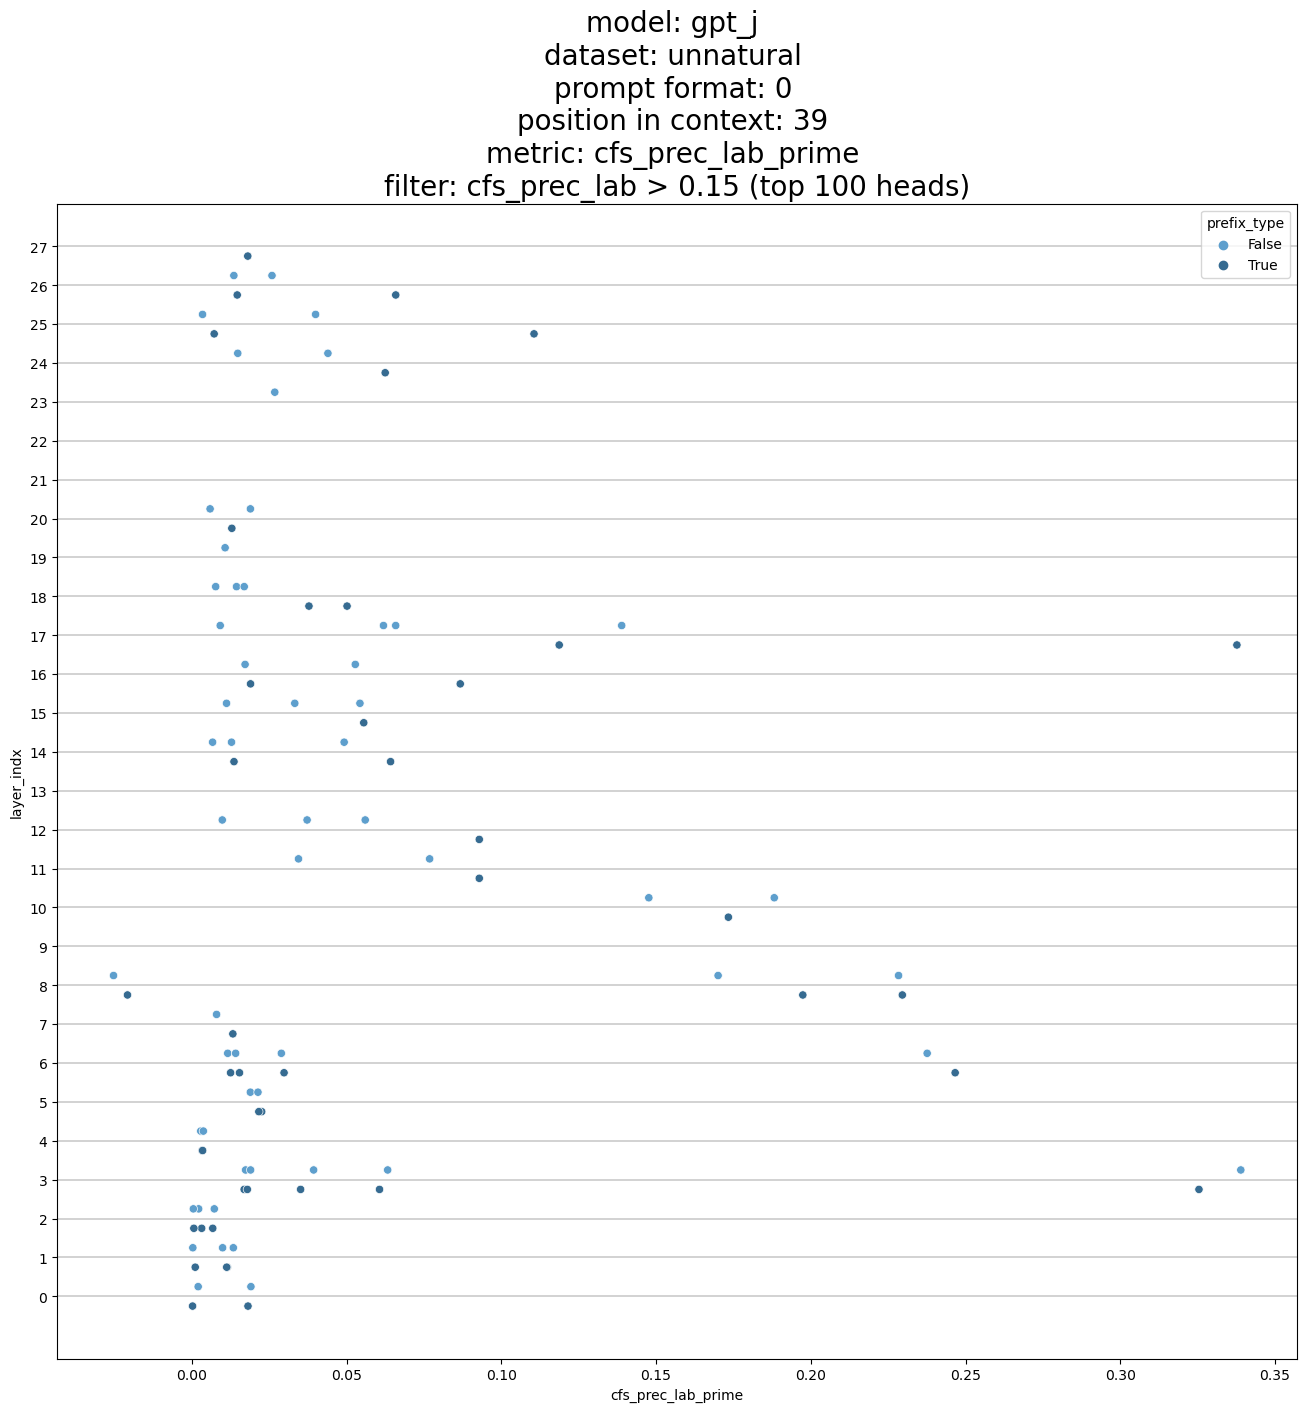

In [15]:
plot_attn_metrics_compressed(
    attn_metrics_df.copy(), metrics, filters, demo_indx, title_params
)